Zasada se fokusiramo na otklanjanjem outliera kod pojedinih hotela i to za ostvarene dolaske, moguće je proširiti na anomalije
 i kod otkazivanja, što bi ukazivalo da je neočekivana potražnja za hotelom te bi se možda moglo tumačiti zbog čega je došlo do toga, ali isto je tako korisno i ako vidimo da je veći broj otkazivanja kod cijenovnih anomalija
 

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime

dataset_path = '../data/raw/export_df.parquet'

ČLANAK https://arxiv.org/pdf/2004.00433.pdf

- An outlier is an observation with at least one variable having an unusual value.
- A univariate outlier is an observation with a variable that has an unusual value.
- A multivariate outlier is an observation with at least two variables having unusual values.

- Na kojeme vremenskom okviru gledati outliere? 
- Kako pohraniti podatke na tjednoj razini u neku smislenu cjelinu?
    (agregacija na tjednoj razini u neku smislenu cjelinu, pogotovo s kategoričkim varijablama)

## Učitavanje podataka

In [22]:
DATA_WO_CANCELLATIONS_PATH = '../data/interim/data_wo_cancel.parquet'
DATA_HOTEL0_PATH = '../data/interim/data_wo_cancel_hotel0.parquet'
DATA_HOTEL1_PATH = '../data/interim/data_wo_cancel_hotel1.parquet'


In [23]:
data = pd.read_parquet(DATA_WO_CANCELLATIONS_PATH)
dataResort = pd.read_parquet(DATA_HOTEL0_PATH)
dataCity = pd.read_parquet(DATA_HOTEL1_PATH)

## Dnevna razina (promatramo tjednu fluktuaciju broja gostiju) za oba hotela

In [24]:
NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
NumberOfGuestsDailyCity.head(5)

ukupno_gostiju
datum_dolaska                
2015-01-01               10.0
2015-01-02                6.0
2015-01-03               11.0
2015-01-04                8.0
2015-01-05                4.0

In [25]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head(5)

ukupno_gostiju
datum_dolaska                
2015-07-01               67.0
2015-07-02               72.0
2015-07-03               59.0
2015-07-04               80.0
2015-07-05               80.0

##### Priprema podataka za dnevnu univarijatnu analizu


In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [27]:
daily_city_data = NumberOfGuestsDailyCity['ukupno_gostiju'].values.reshape(-1,1)
daily_city_data_stand = scaler.fit_transform(daily_city_data)

In [28]:
daily_resort_data = NumberOfGuestsDailyResort['ukupno_gostiju'].values.reshape(-1,1)
daily_resort_data_stand = scaler.fit_transform(daily_resort_data)

In [29]:
pd_resort_daily_data = NumberOfGuestsDailyResort[['ukupno_gostiju']].copy()
pd_resort_daily_data['ukupno_gostiju'] = scaler.fit_transform(pd_resort_daily_data['ukupno_gostiju'].values.reshape(-1,1))


In [30]:
pd_city_daily_data = NumberOfGuestsDailyCity[['ukupno_gostiju']].copy()
pd_city_daily_data['ukupno_gostiju'] = scaler.fit_transform(pd_city_daily_data['ukupno_gostiju'].values.reshape(-1,1))


### Naivan pristup : interkvartalni rang

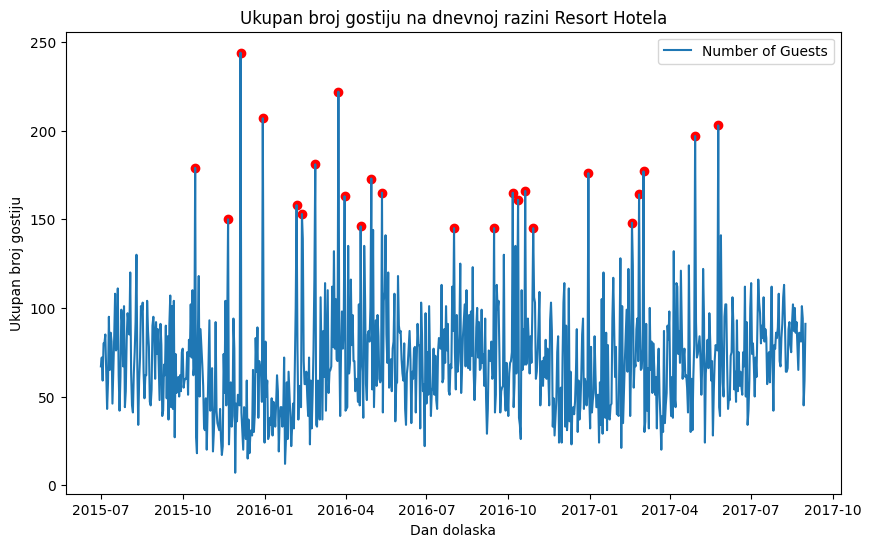

In [76]:
q11 = np.percentile(NumberOfGuestsDailyResort['ukupno_gostiju'], 25)
q31 = np.percentile(NumberOfGuestsDailyResort['ukupno_gostiju'],75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((NumberOfGuestsDailyResort['ukupno_gostiju'] < q11 - threshold1) | (NumberOfGuestsDailyResort['ukupno_gostiju'] > q31 + threshold1))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyResort.index, NumberOfGuestsDailyResort['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers1[0]:
    plt.scatter(NumberOfGuestsDailyResort.index[outlier], NumberOfGuestsDailyResort['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini Resort Hotela')
plt.legend()
plt.show()


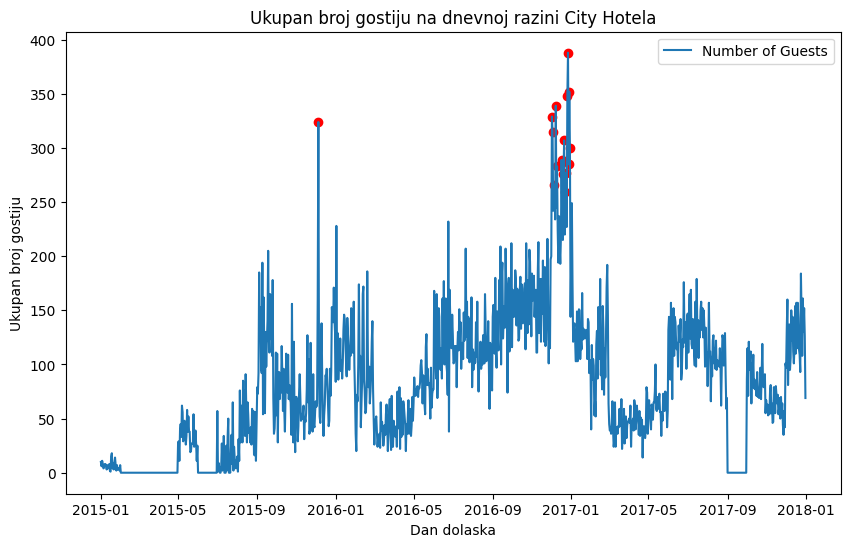

In [77]:
q12 = np.percentile(NumberOfGuestsDailyCity ['ukupno_gostiju'], 25)
q32 = np.percentile(NumberOfGuestsDailyCity['ukupno_gostiju'],75)
iqr2 = q32 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((NumberOfGuestsDailyCity['ukupno_gostiju'] < q12 - threshold2) | (NumberOfGuestsDailyCity['ukupno_gostiju'] > q32 + threshold2))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyCity.index, NumberOfGuestsDailyCity['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers2[0]:
    plt.scatter(NumberOfGuestsDailyCity.index[outlier], NumberOfGuestsDailyCity['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini City Hotela')
plt.legend()
plt.show()

### ADTK OutlierDetector

" performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API."

In [78]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor


In [79]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_resort = outlier_detector.fit_detect(NumberOfGuestsDailyResort)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True False False False False False False False False False False Fa

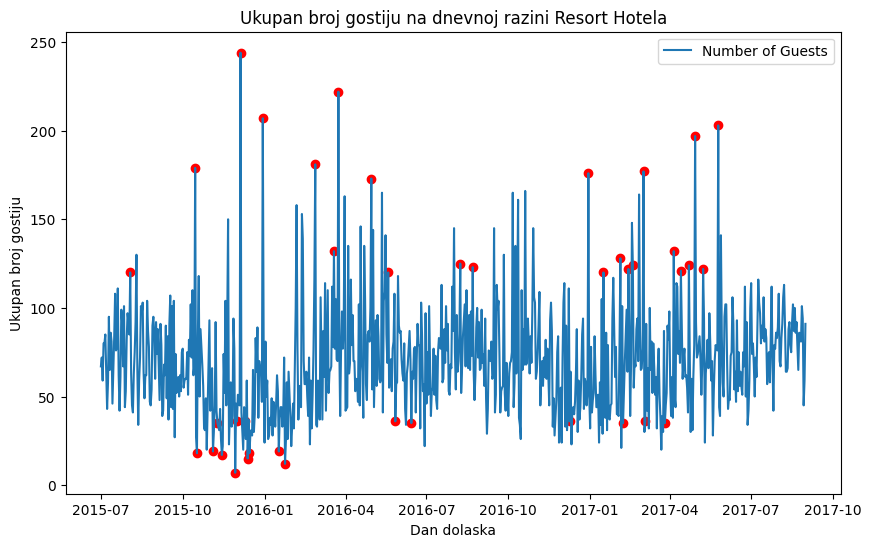

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyResort.index, NumberOfGuestsDailyResort['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_resort[anomalies_resort].index:
    if anomaly_date in NumberOfGuestsDailyResort.index:
        plt.scatter(anomaly_date, NumberOfGuestsDailyResort.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini Resort Hotela')
plt.legend()
plt.show()

In [81]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_city = outlier_detector.fit_detect(NumberOfGuestsDailyCity)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  is_outliers.loc[df.dropna().index] = (


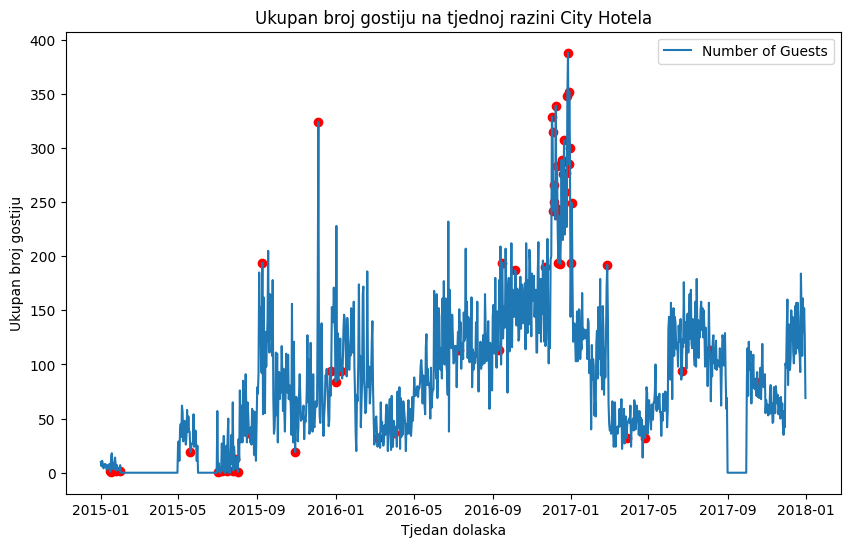

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyCity.index, NumberOfGuestsDailyCity['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_city[anomalies_city].index:
    if anomaly_date in NumberOfGuestsDailyCity.index:
        plt.scatter(anomaly_date, NumberOfGuestsDailyCity.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()

### (Unsupervised) Isolation Forests na univarijatnim podacima 

In [83]:
from sklearn.ensemble import IsolationForest 

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

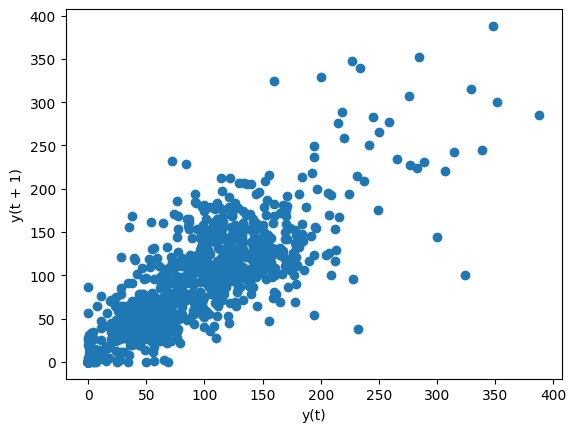

In [84]:
pd.plotting.lag_plot(NumberOfGuestsDailyCity, lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

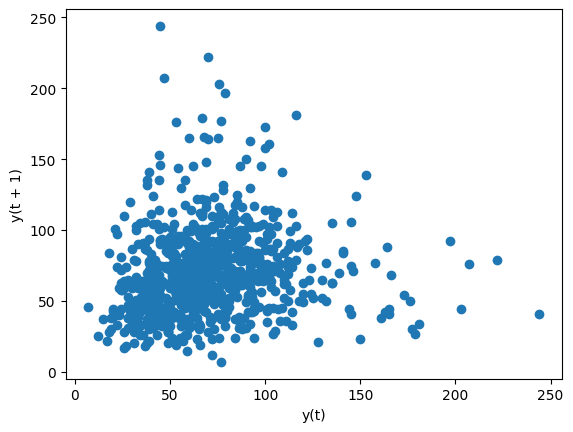

In [85]:
pd.plotting.lag_plot(NumberOfGuestsDailyResort, lag=1)

In [86]:
outliers_fraction = float(0.05)

In [87]:
if_model_city = IsolationForest(random_state = 0, 
                                contamination = outliers_fraction,
                                bootstrap=False,
                                verbose=True
                                )

In [88]:
if_model_city.fit(daily_city_data_stand)

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [89]:
NumberOfGuestsDailyCity['score'] = if_model_city.decision_function(daily_city_data_stand )
NumberOfGuestsDailyCity['anomaly_value'] = if_model_city.predict(daily_city_data_stand )
NumberOfGuestsDailyCity.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-01-01               10.0  0.001459              1
2015-01-02                6.0  0.006132              1
2015-01-03               11.0  0.000000              1
2015-01-04                8.0  0.004427              1
2015-01-05                4.0  0.014540              1

anomaly_value
 1    1042
-1      54
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

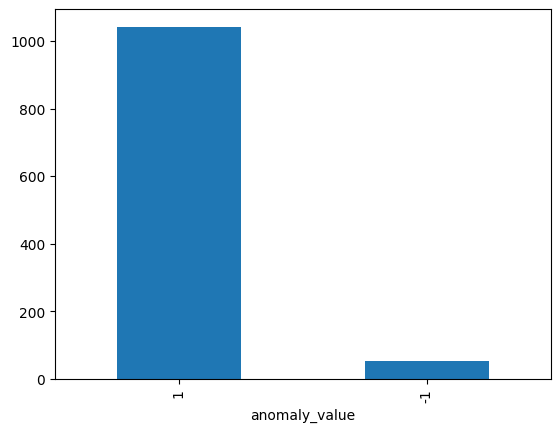

In [90]:
outliers_city = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['anomaly_value'] == -1]
outlier_index = list(outliers_city.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsDailyCity['anomaly_value'].value_counts())
NumberOfGuestsDailyCity['anomaly_value'].value_counts().plot(kind = 'bar')

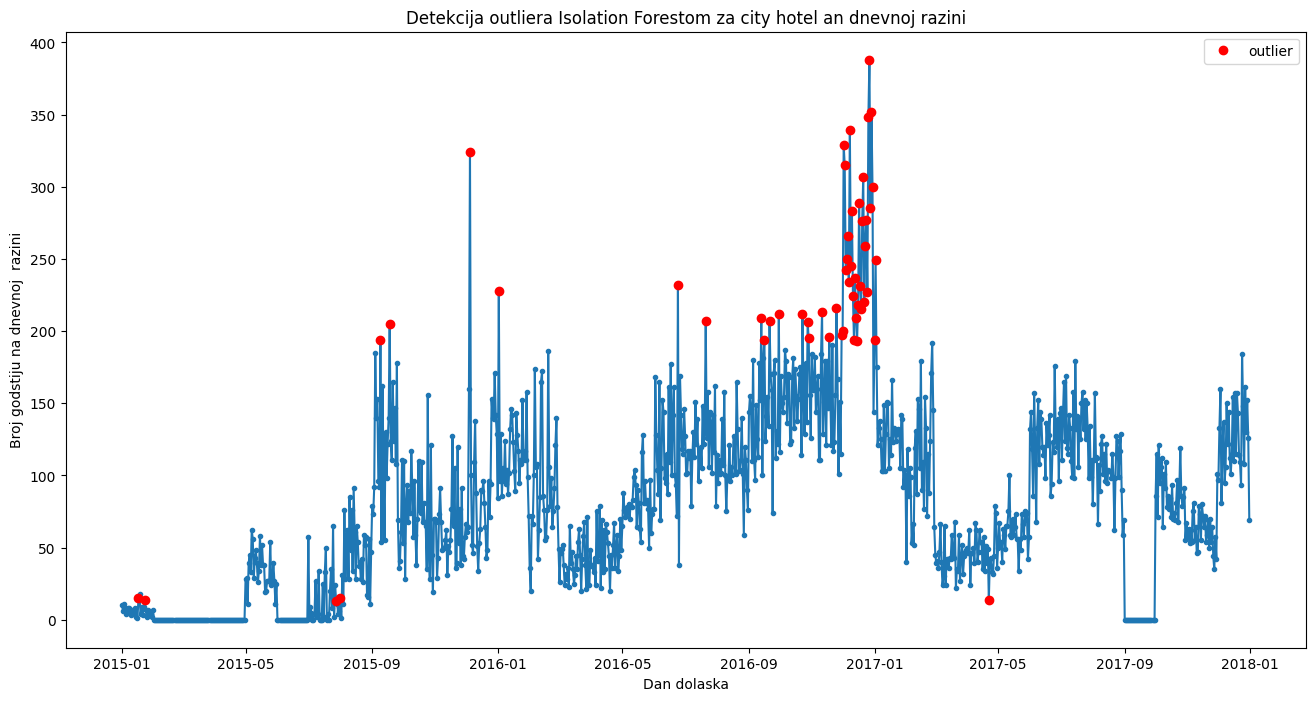

In [91]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker = '.')
plt.plot(outliers_city['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za city hotel an dnevnoj razini')

plt.xlabel('Dan dolaska')
plt.ylabel('Broj godstiju na dnevnoj  razini')
plt.legend()

In [92]:
outliers_fraction = float(0.05)

In [93]:
if_model_resort = IsolationForest(random_state = 0, 
                                  contamination = outliers_fraction ,
                                  bootstrap=False,
                                  verbose=True
                                 )

In [94]:
if_model_resort.fit(daily_resort_data_stand) 

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [95]:
NumberOfGuestsDailyResort['score'] = if_model_resort.decision_function(daily_resort_data_stand) 
NumberOfGuestsDailyResort['anomaly_value'] = if_model_resort.predict(daily_resort_data_stand) 
NumberOfGuestsDailyResort.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-07-01               67.0  0.180174              1
2015-07-02               72.0  0.163373              1
2015-07-03               59.0  0.184900              1
2015-07-04               80.0  0.161944              1
2015-07-05               80.0  0.161944              1

anomaly_value
 1    754
-1     39
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

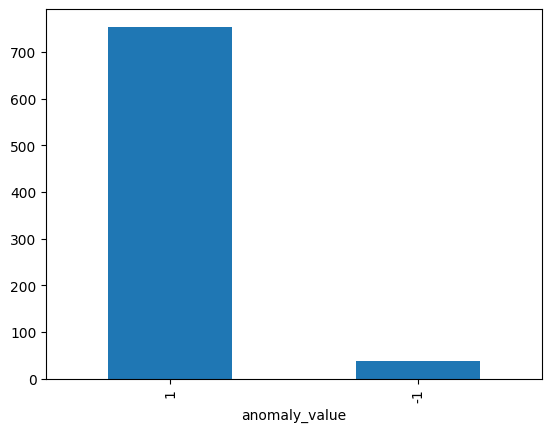

In [96]:
outliers_resort = NumberOfGuestsDailyResort[NumberOfGuestsDailyResort['anomaly_value'] == -1]
outlier_index_resort = list(outliers_resort.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsDailyResort['anomaly_value'].value_counts())
NumberOfGuestsDailyResort['anomaly_value'].value_counts().plot(kind = 'bar')

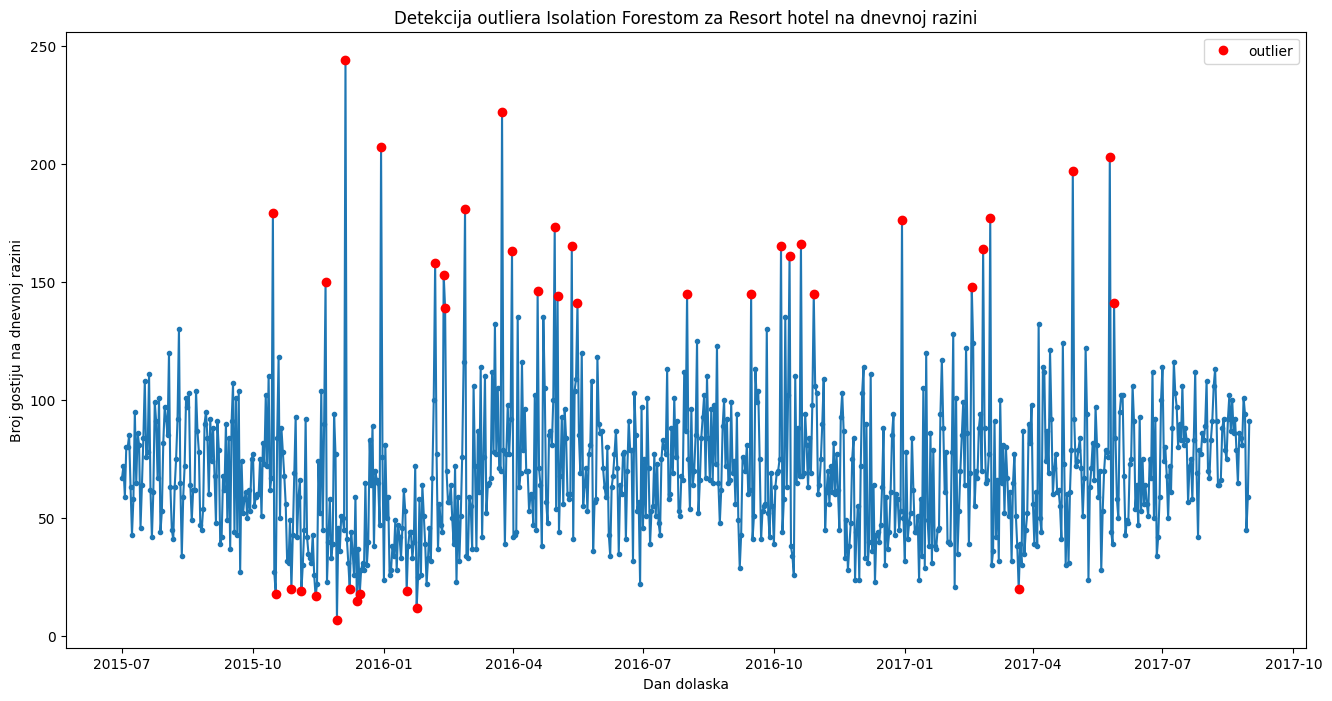

In [97]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsDailyResort['ukupno_gostiju'], marker = '.')
plt.plot(outliers_resort['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za Resort hotel na dnevnoj razini')

plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()

### One class SVM

In [98]:
from sklearn.svm import OneClassSVM

In [99]:
outliers_fraction = float(0.05)

In [100]:
osvm_city = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_city.fit(daily_city_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [101]:
NumberOfGuestsDailyCity['anomaly_value_osvm'] = osvm_city.predict(daily_city_data_stand)

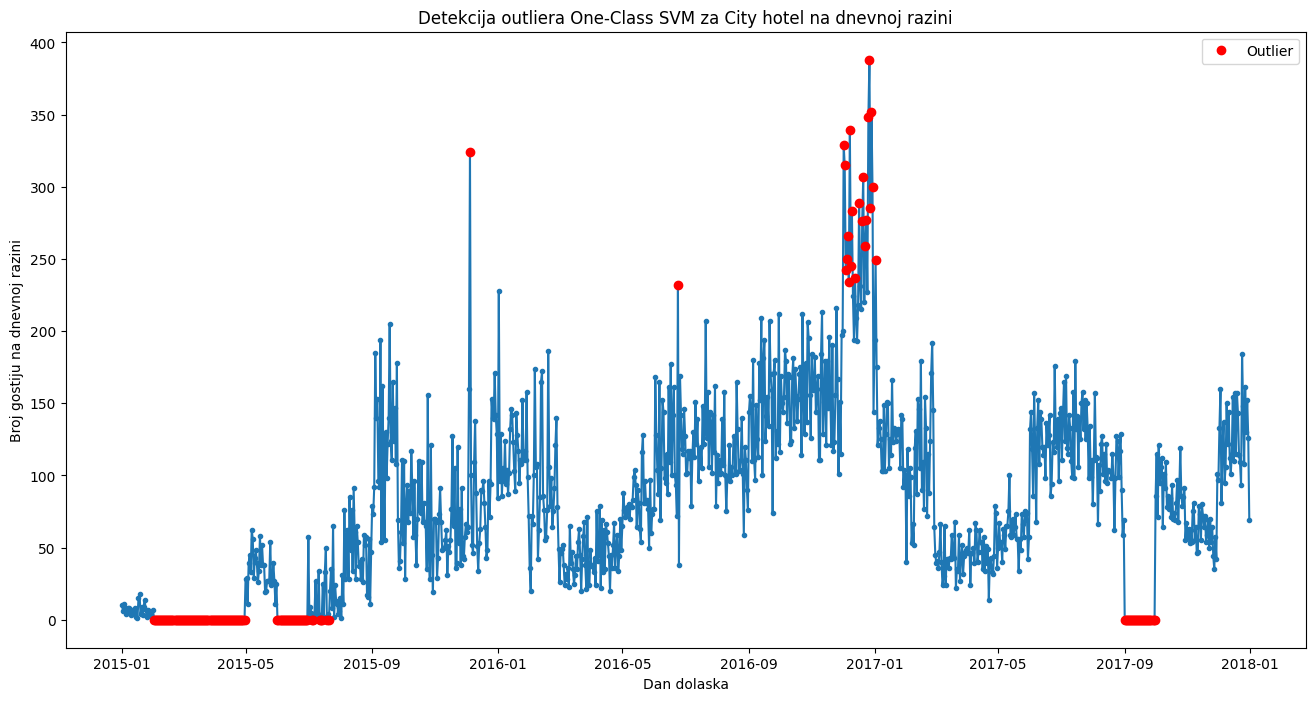

In [103]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za City hotel na dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()
plt.show()


In [104]:
osvm_resort = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_resort.fit(daily_resort_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [106]:
NumberOfGuestsDailyResort['anomaly_value_osvm'] = osvm_resort.predict(daily_resort_data_stand)

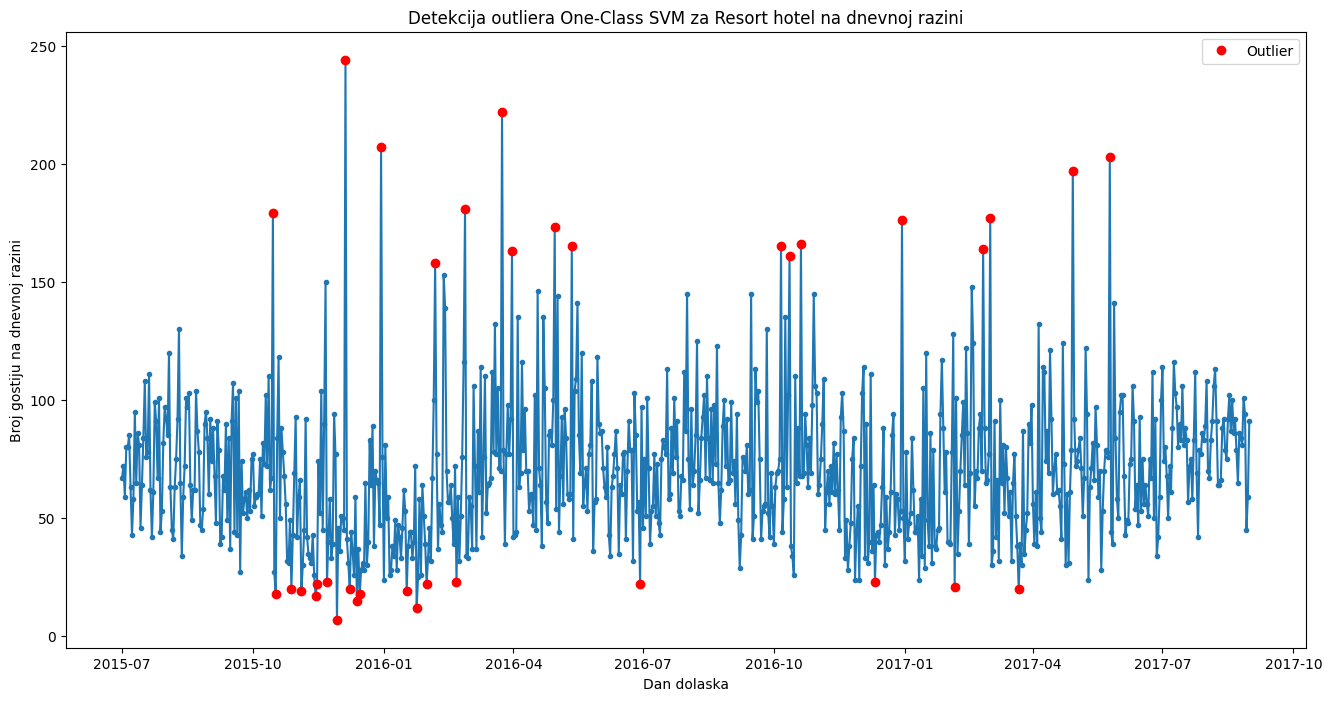

In [107]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyResort['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsDailyResort[NumberOfGuestsDailyResort['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za Resort hotel na dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()
plt.show()


### K Means Clustering

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
import matplotlib.cm as cm

X = pd_resort_daily_data[['ukupno_gostiju']].values

range_n_clusters = [2, 3, 4,5,6,7,8,9,10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], np.zeros_like(X), marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], np.zeros_like(centers[:, 0]), marker="o", c="white", alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers):
        ax2.scatter(c[0], 0, marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for 'ukupno_gostiju'")
    ax2.set_ylabel("Zeroes (One-dimensional data)")

    plt.suptitle("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold")

plt.show()

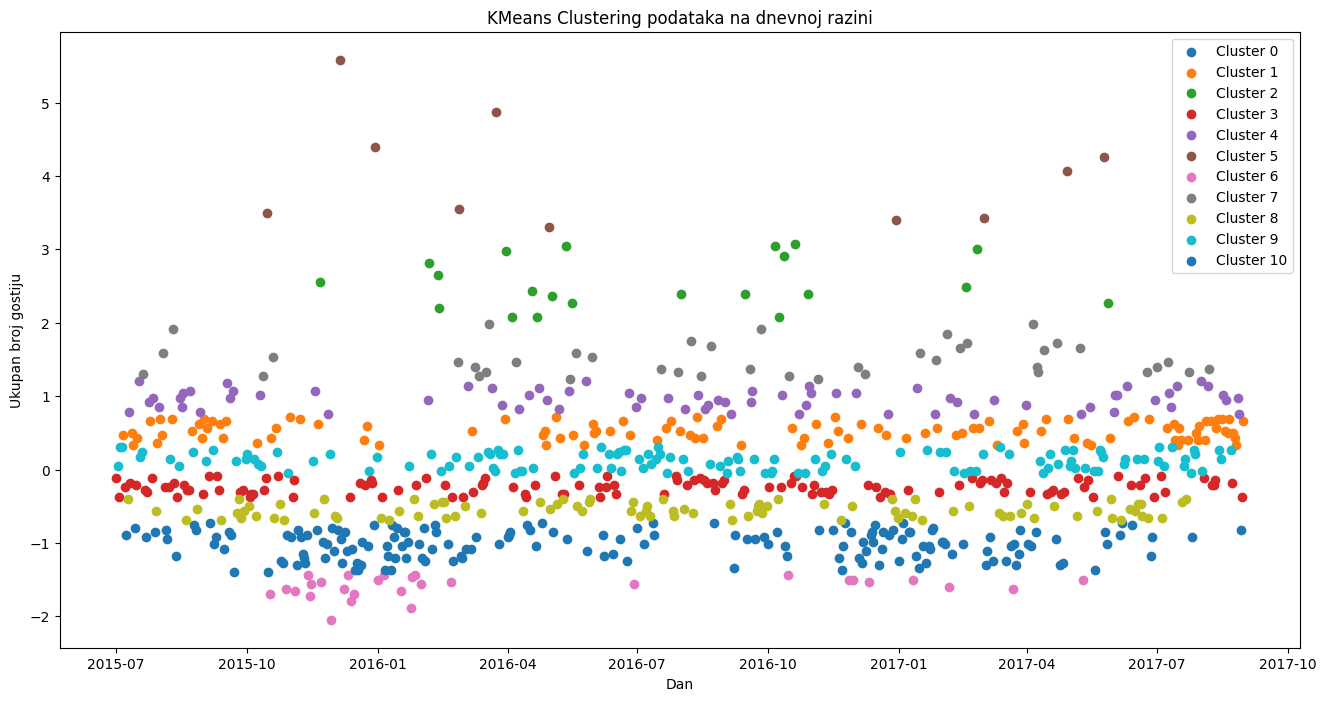

In [113]:
kmeans = KMeans(n_clusters=11, random_state=0)
clusters = kmeans.fit_predict(pd_resort_daily_data)
plt.figure(figsize=(16, 8))

for cluster in range(11):
    cluster_data = pd_resort_daily_data[clusters == cluster]
    plt.scatter(cluster_data.index, cluster_data['ukupno_gostiju'], label=f'Cluster {cluster}')

plt.title('KMeans Clustering podataka na dnevnoj razini')
plt.xlabel('Dan')
plt.ylabel('Ukupan broj gostiju')
plt.legend()
plt.show()

In [117]:
NumberOfGuestsDailyResort['kmeans_clusters'] = clusters

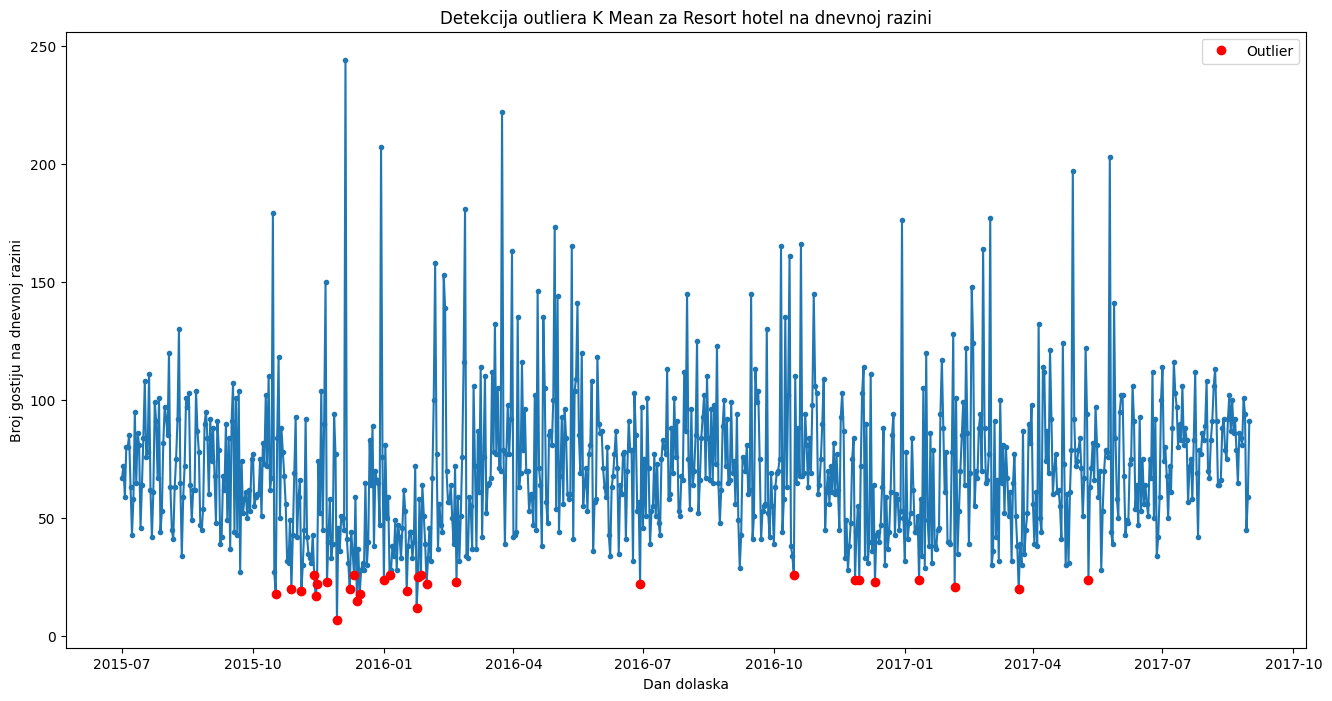

In [118]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyResort['ukupno_gostiju'], marker='.')

anomalies_kmeans = NumberOfGuestsDailyResort[NumberOfGuestsDailyResort['kmeans_clusters'] == 6]  #iznimno sporno 
plt.plot(anomalies_kmeans['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera K Mean za Resort hotel na dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()
plt.show()


### DBSCAN

In [119]:
from sklearn.cluster import DBSCAN

In [120]:
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_resort = outlier_detection.fit_predict(pd_resort_daily_data)

In [121]:
NumberOfGuestsDailyResort['anomaly_value_dbscan'] = clusters_resort

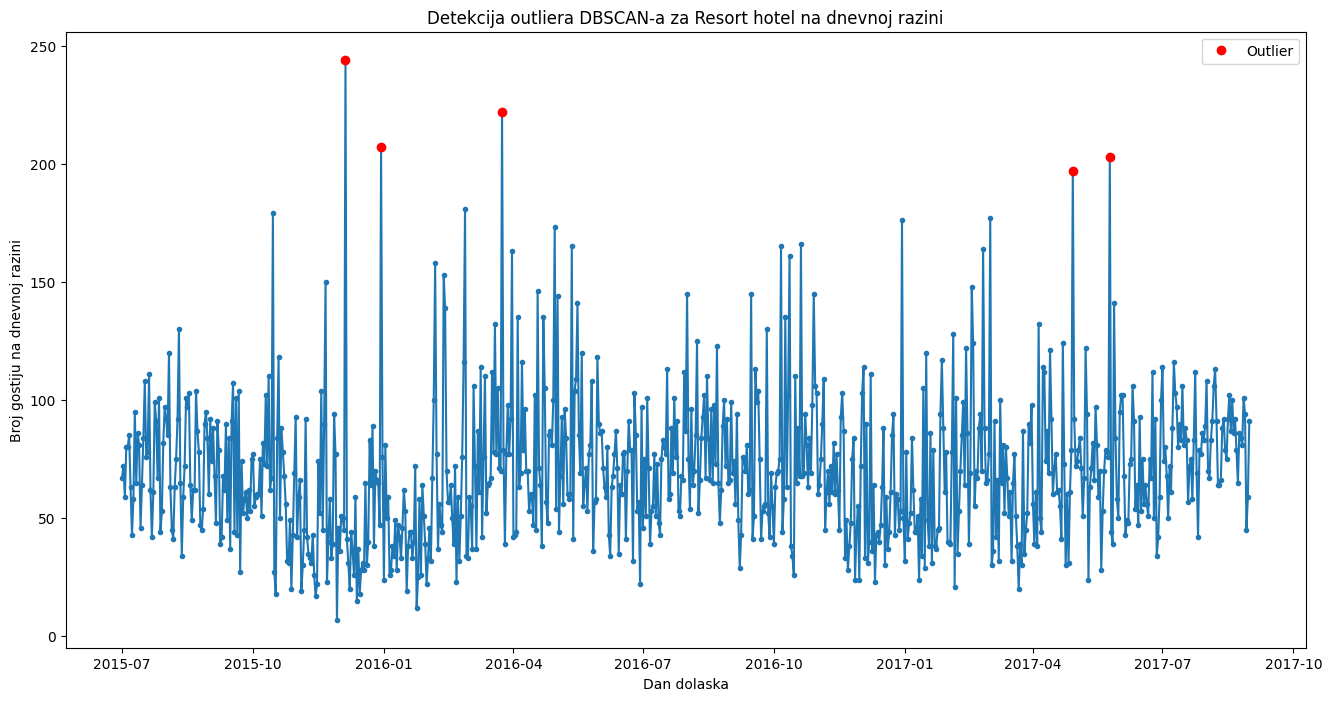

In [122]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyResort['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsDailyResort[NumberOfGuestsDailyResort['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za Resort hotel na dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()
plt.show()


In [123]:
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_city = outlier_detection.fit_predict(pd_city_daily_data)

In [124]:
NumberOfGuestsDailyCity['anomaly_value_dbscan'] = clusters_city


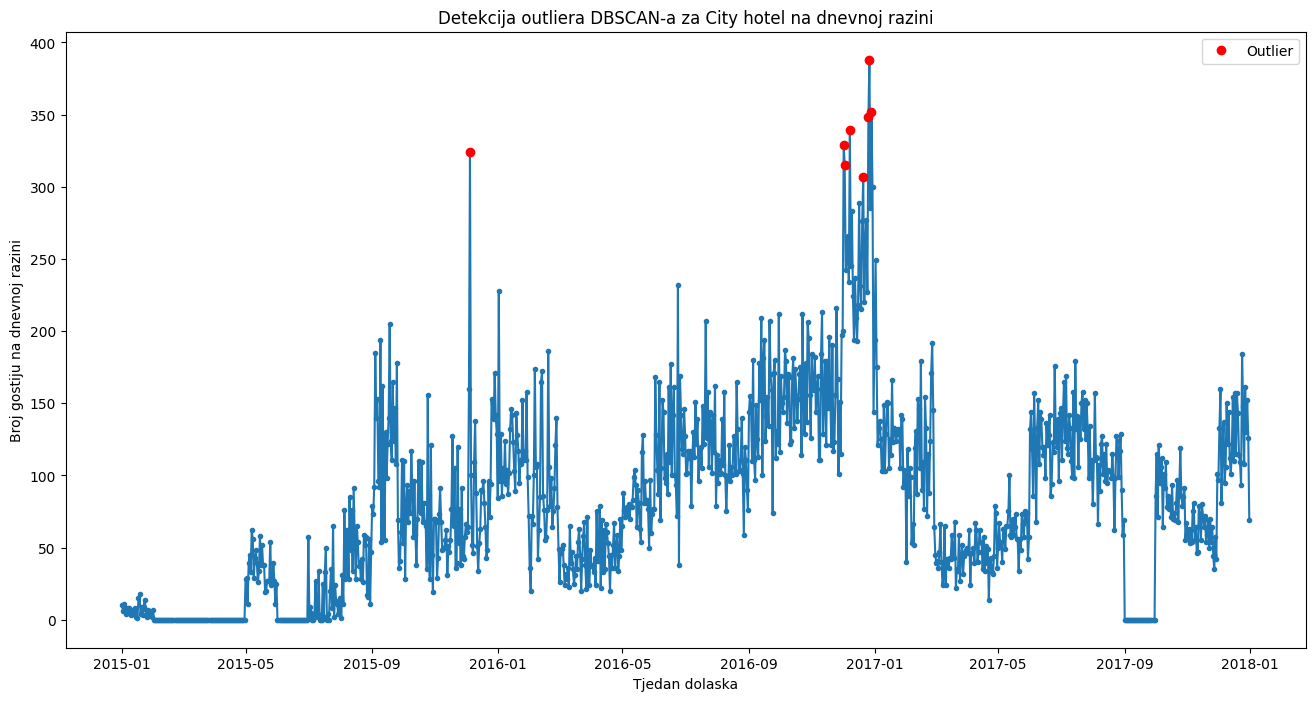

In [125]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za City hotel na dnevnoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')
plt.legend()
plt.show()


## Tjedna razina (promatramo tjednu fluktuaciju broja gostiju) za oba hotela

In [31]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('W').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

ukupno_gostiju
datum_dolaska                
2015-01-04               35.0
2015-01-11               42.0
2015-01-18               54.0
2015-01-25               48.0
2015-02-01               27.0

In [32]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('W').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

ukupno_gostiju
datum_dolaska                
2015-07-05              358.0
2015-07-12              495.0
2015-07-19              537.0
2015-07-26              533.0
2015-08-02              554.0

##### Priprema podataka za tjednu univarijatnu analizu


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [34]:
weekly_city_data = NumberOfGuestsWeeklyCity['ukupno_gostiju'].values.reshape(-1,1)
weekly_city_data_stand = scaler.fit_transform(weekly_city_data)

In [35]:
weekly_resort_data = NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)
weekly_resort_data_stand = scaler.fit_transform(weekly_resort_data)

In [36]:
pd_resort_weekly_data = NumberOfGuestsWeeklyResort[['ukupno_gostiju']].copy()
pd_resort_weekly_data['ukupno_gostiju'] = scaler.fit_transform(pd_resort_weekly_data['ukupno_gostiju'].values.reshape(-1,1))


In [37]:
pd_city_weekly_data = NumberOfGuestsWeeklyCity[['ukupno_gostiju']].copy()
pd_city_weekly_data['ukupno_gostiju'] = scaler.fit_transform(pd_city_weekly_data['ukupno_gostiju'].values.reshape(-1,1))


### Naivan pristup : interkvartalni rang

 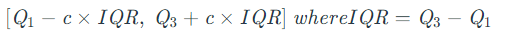

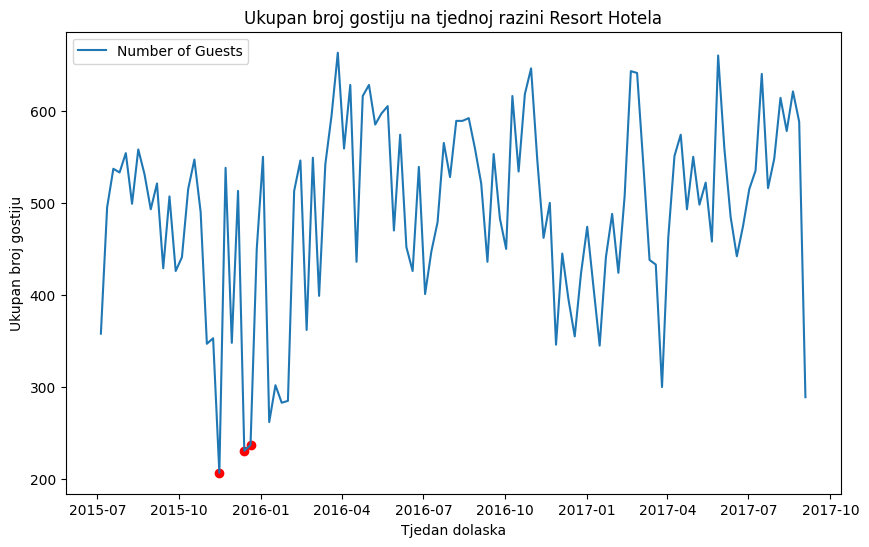

In [30]:
q11 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'], 25)
q31 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'],75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((NumberOfGuestsWeeklyResort['ukupno_gostiju'] < q11 - threshold1) | (NumberOfGuestsWeeklyResort['ukupno_gostiju'] > q31 + threshold1))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers1[0]:
    plt.scatter(NumberOfGuestsWeeklyResort.index[outlier], NumberOfGuestsWeeklyResort['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()


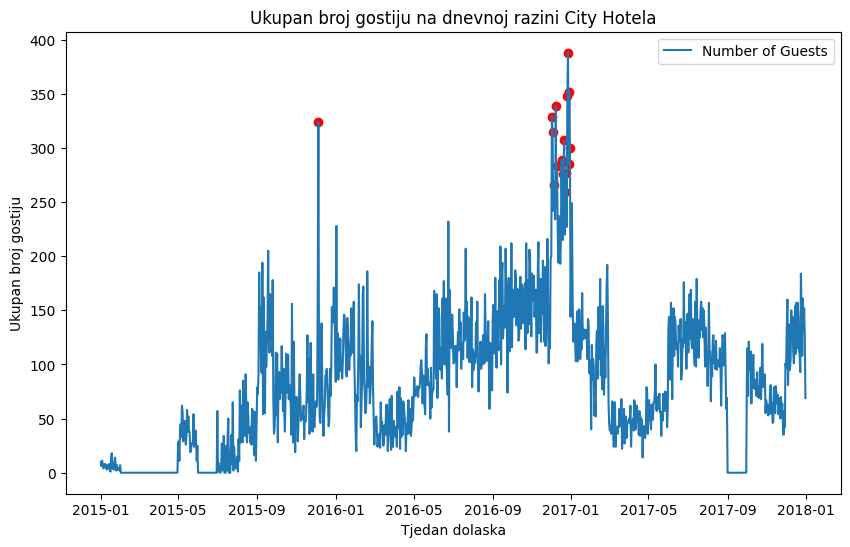

In [31]:
q12 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'], 25)
q32 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'],75)
iqr2 = q32 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((NumberOfGuestsWeeklyCity['ukupno_gostiju'] < q12 - threshold2) | (NumberOfGuestsWeeklyCity['ukupno_gostiju'] > q32 + threshold2))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers2[0]:
    plt.scatter(NumberOfGuestsWeeklyCity.index[outlier], NumberOfGuestsWeeklyCity['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()


### ADTK OutlierDetector

" performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API."

In [32]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

In [33]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_resort = outlier_detector.fit_detect(NumberOfGuestsWeeklyResort)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False  True False False False  True
  True False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]' has dtype incompatible with fl

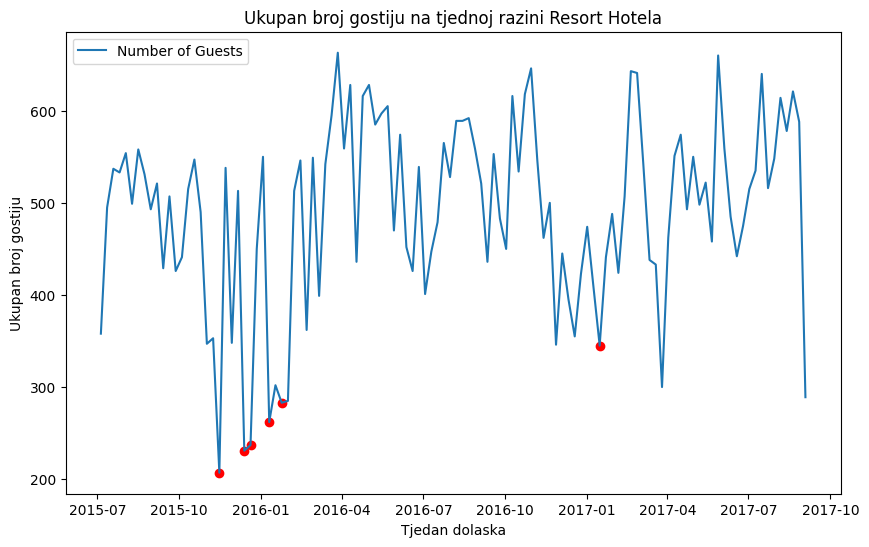

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_resort[anomalies_resort].index:
    if anomaly_date in NumberOfGuestsWeeklyResort.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyResort.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()

In [35]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_city = outlier_detector.fit_detect(NumberOfGuestsWeeklyCity)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False  True  True  True  True  True False False False
 False False False False False False False False False False False Fa

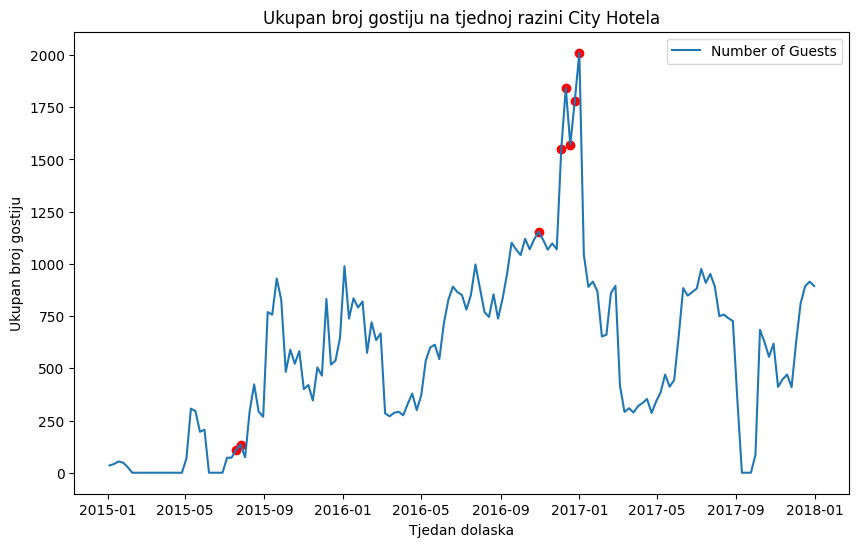

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_city[anomalies_city].index:
    if anomaly_date in NumberOfGuestsWeeklyCity.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyCity.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()

### (Unsupervised) Isolation Forests na univarijatnim podacima 

 Isolation Score for the Isolation Forest


 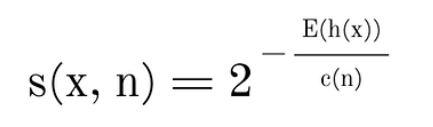

- h(x) - This is the average search height for 'x' from the isolation trees constructed 
- c(n) is the average search height (or depth) to find any general node in your isolation trees
- n is the number of external nodes in the Binary Search Tree (sample size)
- Note: External nodes are leaf nodes that could not be split further and reside at the bottom of the tree. 

In [37]:
from sklearn.ensemble import IsolationForest

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

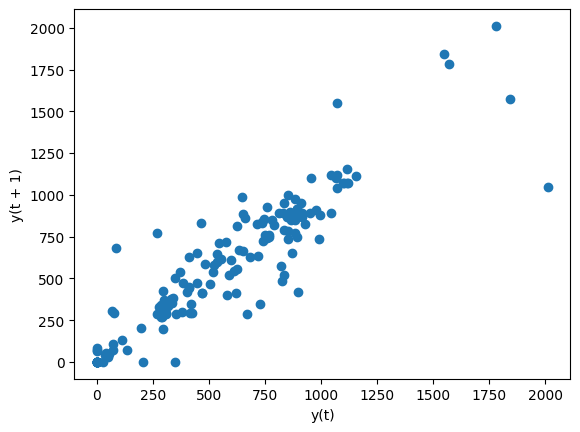

In [38]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyCity, lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

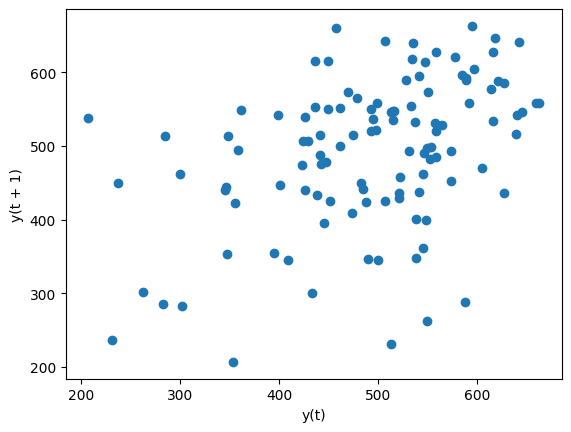

In [39]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyResort, lag=1)

In [40]:
outliers_fraction = float(0.05)

In [41]:
if_model_city = IsolationForest(random_state = 0, 
                                contamination = outliers_fraction,
                                bootstrap=False,
                                verbose=True
                                )

In [45]:
if_model_city.fit(weekly_city_data_stand)

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [46]:
NumberOfGuestsWeeklyCity['score'] = if_model_city.decision_function(weekly_city_data_stand )
NumberOfGuestsWeeklyCity['anomaly_value'] = if_model_city.predict(weekly_city_data_stand )
NumberOfGuestsWeeklyCity.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-01-04               35.0  0.022843              1
2015-01-11               42.0  0.031476              1
2015-01-18               54.0  0.029678              1
2015-01-25               48.0  0.041035              1
2015-02-01               27.0 -0.009033             -1

anomaly_value
 1    149
-1      8
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

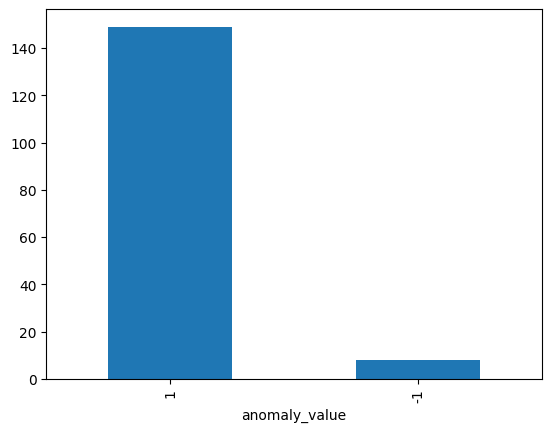

In [47]:
outliers_city = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value'] == -1]
outlier_index = list(outliers_city.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyCity['anomaly_value'].value_counts())
NumberOfGuestsWeeklyCity['anomaly_value'].value_counts().plot(kind = 'bar')

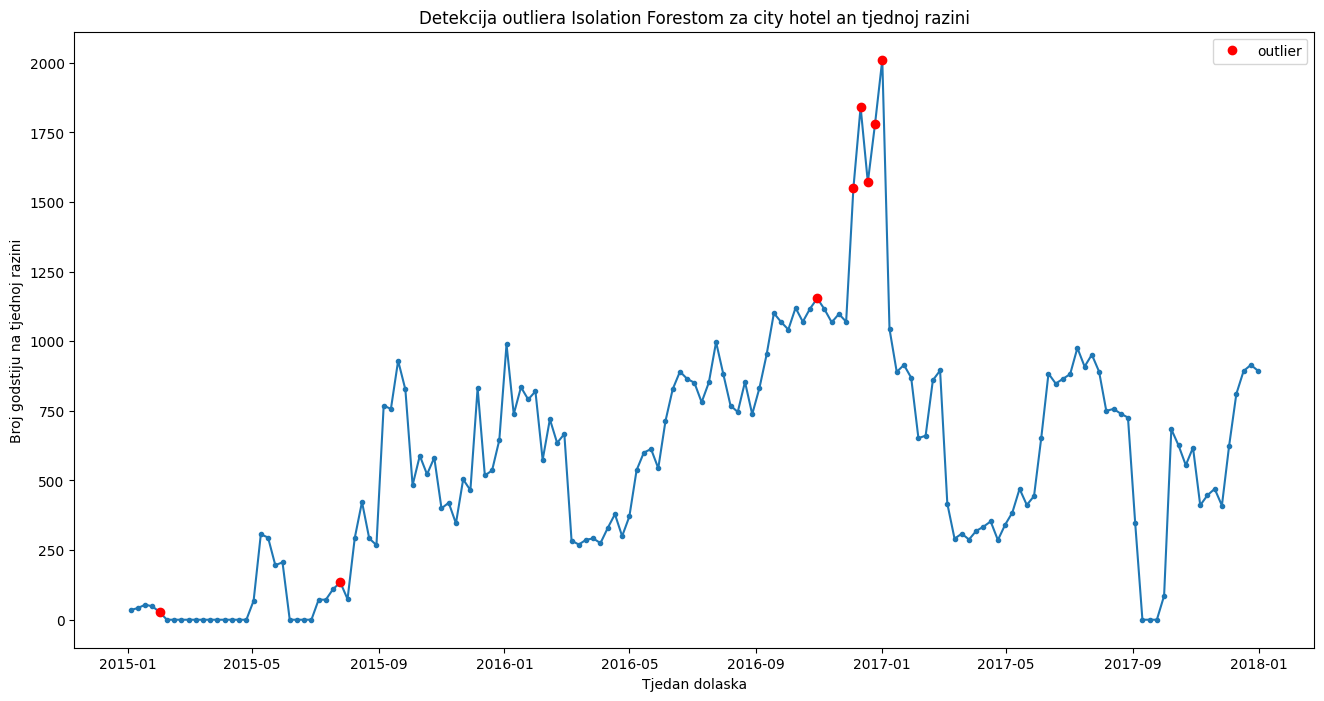

In [48]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker = '.')
plt.plot(outliers_city['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za city hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj godstiju na tjednoj razini')
plt.legend()

In [52]:
outliers_fraction = float(0.05)

In [53]:
if_model_resort = IsolationForest(random_state = 0, 
                                  contamination = outliers_fraction ,
                                  bootstrap=False,
                                  verbose=True
                                 )

In [54]:
if_model_resort.fit(weekly_resort_data_stand) 

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [56]:
NumberOfGuestsWeeklyResort['score'] = if_model_resort.decision_function(weekly_resort_data_stand) 
NumberOfGuestsWeeklyResort['anomaly_value'] = if_model_resort.predict(weekly_resort_data_stand) 
NumberOfGuestsWeeklyResort.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-07-05              358.0  0.073555              1
2015-07-12              495.0  0.168078              1
2015-07-19              537.0  0.190954              1
2015-07-26              533.0  0.179562              1
2015-08-02              554.0  0.171272              1

anomaly_value
 1    108
-1      6
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

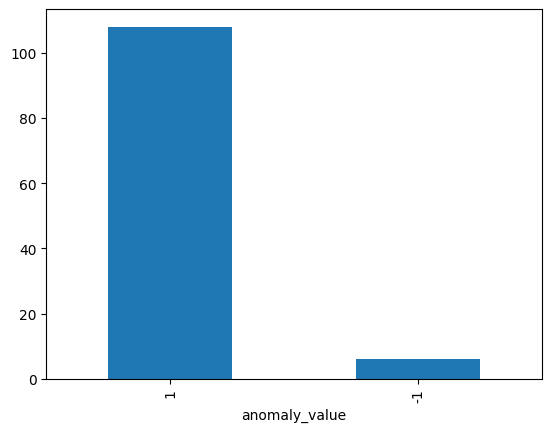

In [57]:
outliers_resort = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value'] == -1]
outlier_index_resort = list(outliers_resort.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyResort['anomaly_value'].value_counts())
NumberOfGuestsWeeklyResort['anomaly_value'].value_counts().plot(kind = 'bar')

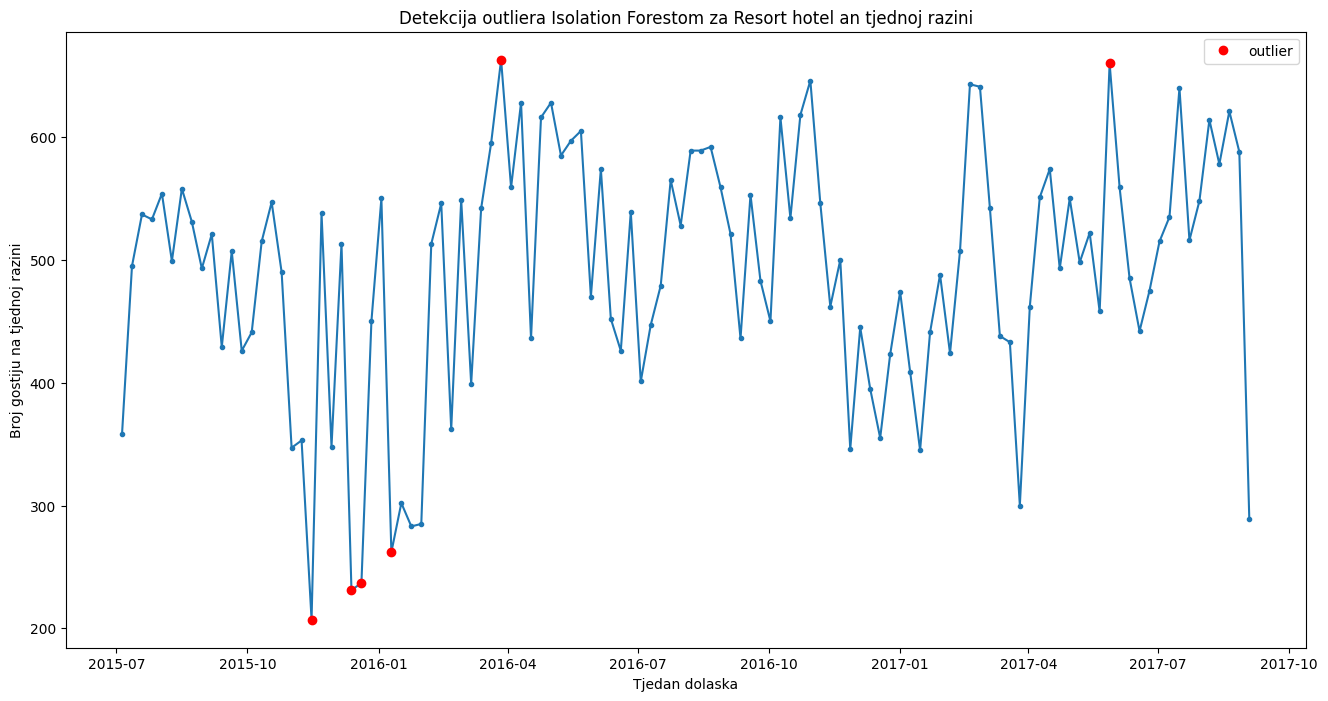

In [58]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker = '.')
plt.plot(outliers_resort['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za Resort hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()

### One class SVM

In [59]:
from sklearn.svm import OneClassSVM

In [60]:
outliers_fraction = float(0.05)

In [61]:
osvm_city = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_city.fit(weekly_city_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [62]:
NumberOfGuestsWeeklyCity['anomaly_value_osvm'] = osvm_city.predict(weekly_city_data_stand)

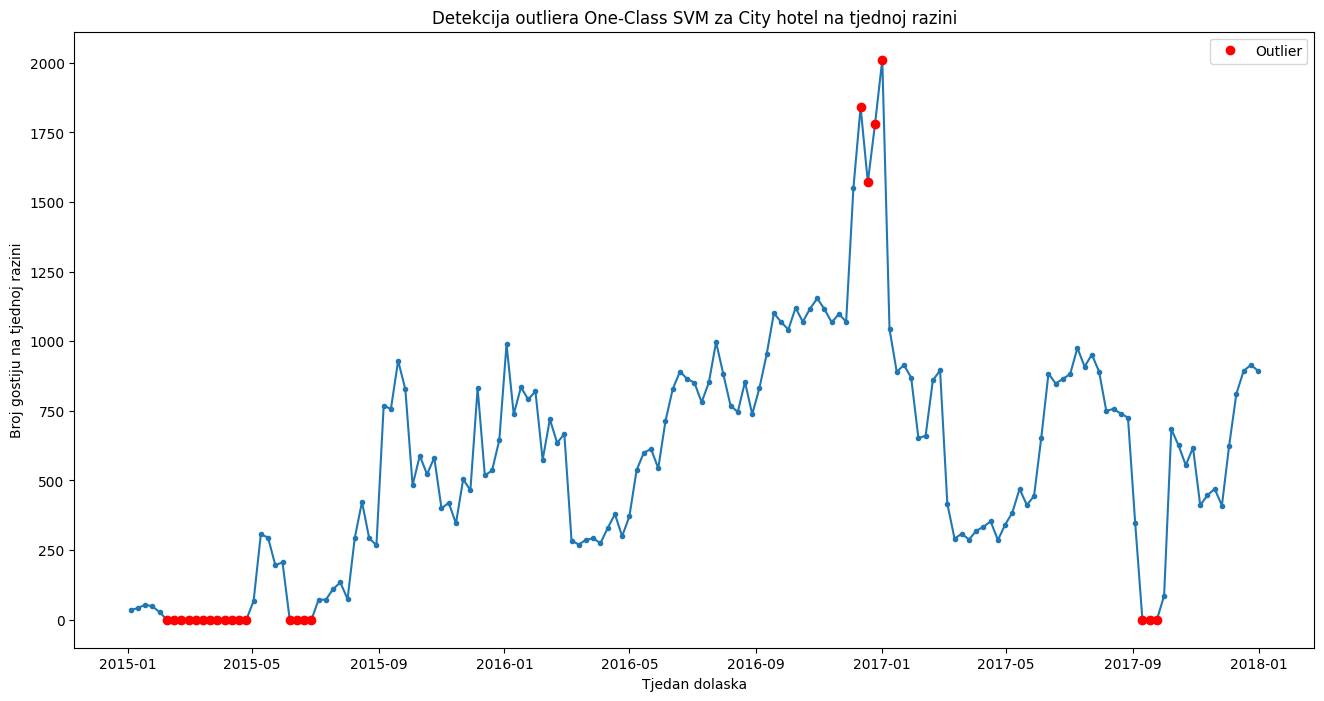

In [63]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [64]:
osvm_resort = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_resort.fit(weekly_resort_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [65]:
NumberOfGuestsWeeklyResort['anomaly_value_osvm'] = osvm_resort.predict(weekly_resort_data_stand)

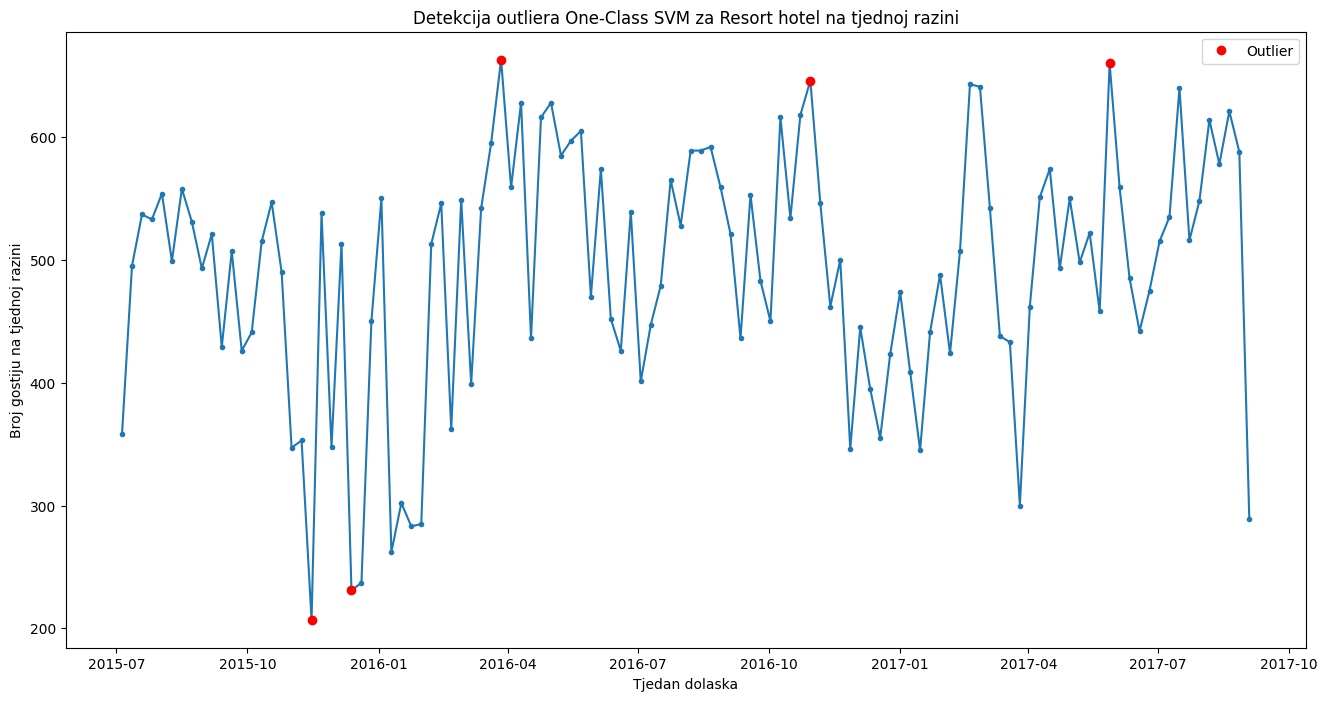

In [67]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


### K Means Clustering

- To use K-Means as an anomaly detection method for time-series data, a sliding windows approach is used
- Note: Keogh and Lin have demonstrated in their work that using sub-sequences of time-series for
clustering algorithms is meaningless. They showed, that the cluster centers found for several runs of the
K-means algorithm on the same dataset are not significantly more similar to each other than the cluster centers
of a random walk dataset. That means that after being asked to present the centroids on a dataset, they could
just present the centroids of a random walk and nobody would be able to distinguish between them.
They also tried other algorithms like hierarchical clustering, which is a deterministic approach compared to
K-means, but received the same result. The same was proved on several datasets which furthermore confirmed
their claim that using sub-sequences of the time-series data for clustering techniques is meaningless. They
also tried different distance measures like Manhattan, L∞ and Mahalanobis distance. Furthermore, by using
K-Means with k = 3 and w = 128 on the famous Cylinder, Bell and Funnell (CBF) dataset, they showed that
the resulting centroids are sinus waves, which are totally different to the instances in the CBF dataset. Several
authors tried to analyse this behavior mathematically , and there have been a lot of attempts to
solve these problem, or at least to show time-series patterns that would work with STSC ]. But the
problems remain generally unsolved.

##### Nedostaci K Means Clusteringa kao metode za detekciju anomalija
- algoritam očekuje da skupine imaju slične oblike,inače ih slabo odvaja
- sve točke idu u algoritam, anomalije pripadaju skupini te utječu na centroidu te radijus skupine (veća granica za detektirat)
- ako imamo dovoljan broj anomalija, skupinu mogu činiti i samo anomalije
- apriori definiranje broja skupina

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

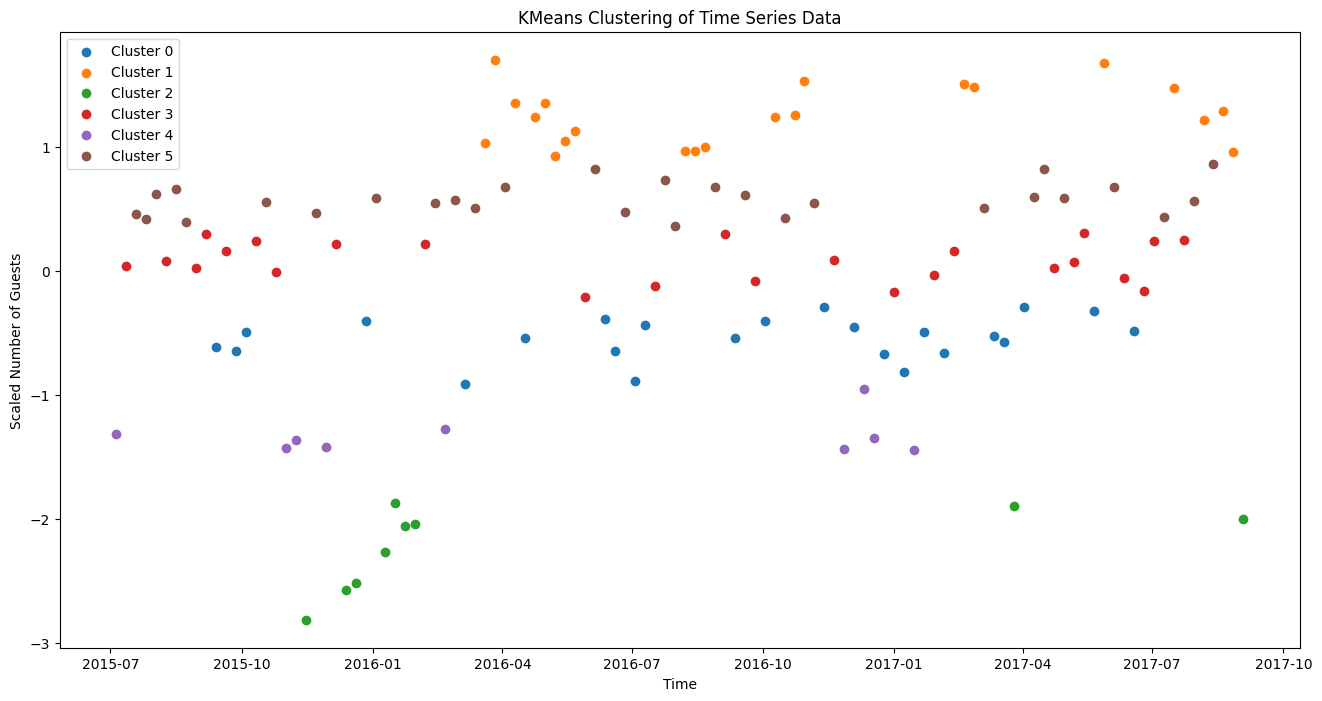

In [85]:

kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(pd_resort_weekly_data)
plt.figure(figsize=(16, 8))

for cluster in range(6):
    cluster_data = pd_resort_weekly_data[clusters == cluster]
    plt.scatter(cluster_data.index, cluster_data['ukupno_gostiju'], label=f'Cluster {cluster}')

plt.title('KMeans Clustering of Time Series Data')
plt.xlabel('Time')
plt.ylabel('Scaled Number of Guests')
plt.legend()
plt.show()

In [86]:
NumberOfGuestsWeeklyResort['kmeans_clusters'] = clusters

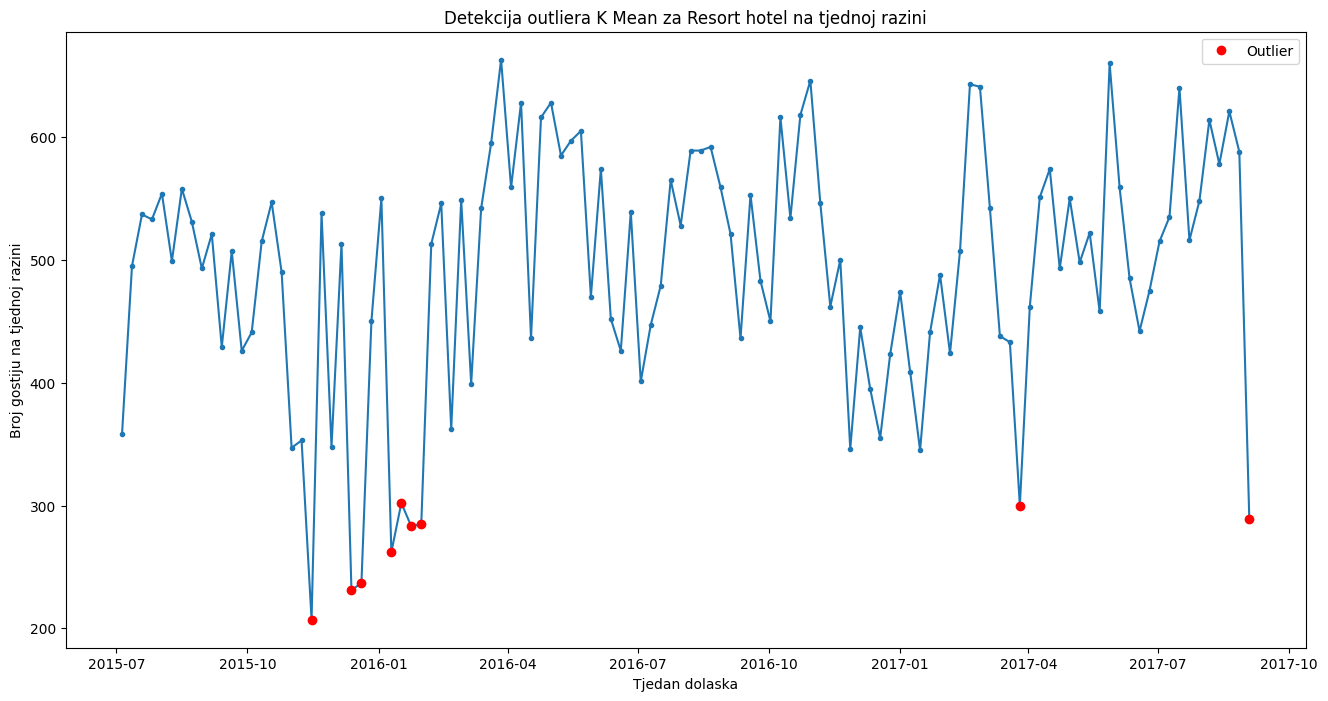

In [87]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_kmeans = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['kmeans_clusters'] == 2]  #iznimno sporno 
plt.plot(anomalies_kmeans['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera K Mean za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [ ]:
import matplotlib.cm as cm

X = pd_resort_weekly_data[['ukupno_gostiju']].values

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], np.zeros_like(X), marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], np.zeros_like(centers[:, 0]), marker="o", c="white", alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers):
        ax2.scatter(c[0], 0, marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for 'ukupno_gostiju'")
    ax2.set_ylabel("Zeroes (One-dimensional data)")

    plt.suptitle("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold")

plt.show()

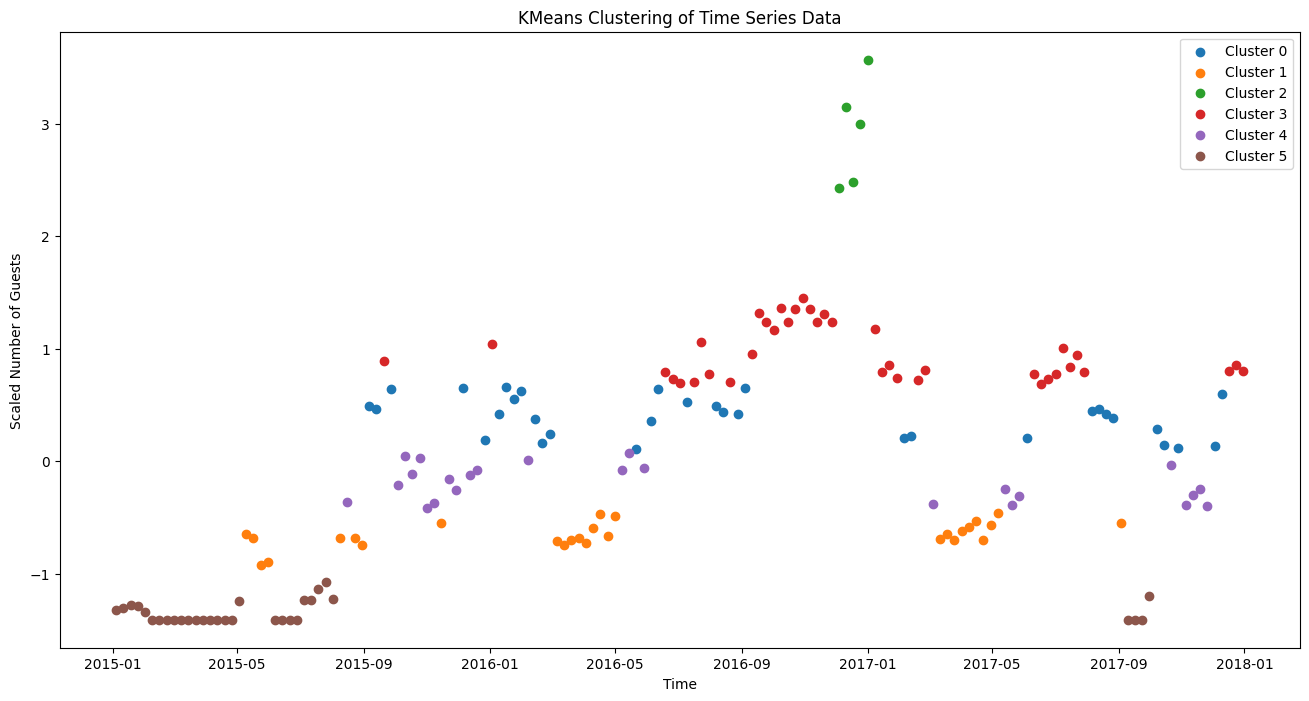

In [93]:
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(pd_city_weekly_data)
plt.figure(figsize=(16, 8))

for cluster in range(6):
    cluster_data = pd_city_weekly_data[clusters == cluster]
    plt.scatter(cluster_data.index, cluster_data['ukupno_gostiju'], label=f'Cluster {cluster}')

plt.title('KMeans Clustering of Time Series Data')
plt.xlabel('Time')
plt.ylabel('Scaled Number of Guests')
plt.legend()
plt.show()

In [94]:
NumberOfGuestsWeeklyCity['kmeans_clusters'] = clusters

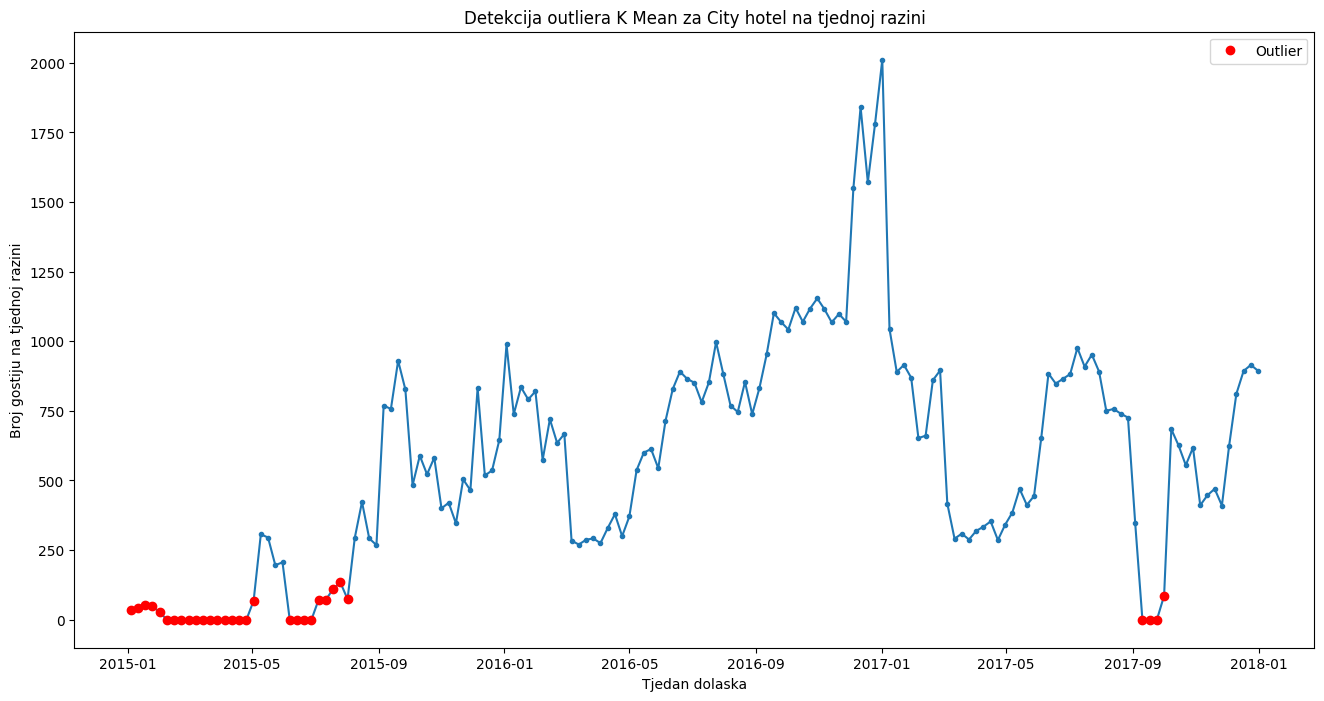

In [95]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_kmeans = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['kmeans_clusters'] == 5]  #iznimno sporno 
plt.plot(anomalies_kmeans['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera K Mean za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


### DBSCAN

In [82]:
from sklearn.cluster import DBSCAN

-eps: float, default=0.5: 
The maximum distance between two samples for one to be considered as in the neighborhood of the othe.
rGlossary for more details.

-min_samples: int, default=5 : The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

In [ ]:
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_resort = outlier_detection.fit_predict(pd_resort_weekly_data)

In [97]:
NumberOfGuestsWeeklyResort['anomaly_value_dbscan'] = clusters_resort


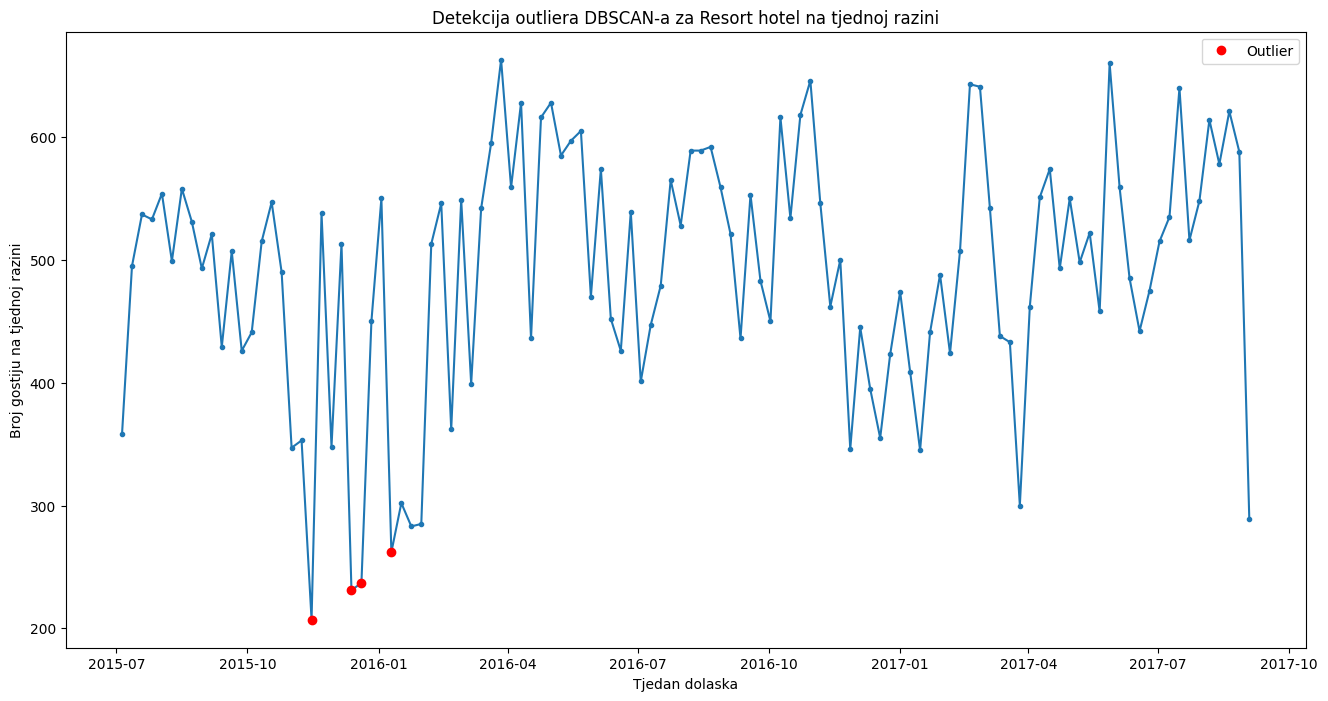

In [98]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [99]:
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_city = outlier_detection.fit_predict(pd_city_weekly_data)

/tmp/ipykernel_2219233/3879244779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_city_weekly_data['ukupno_gostiju'] = scaler.fit_transform(pd_city_weekly_data['ukupno_gostiju'].values.reshape(-1,1))


In [100]:
NumberOfGuestsWeeklyCity['anomaly_value_dbscan'] = clusters_city


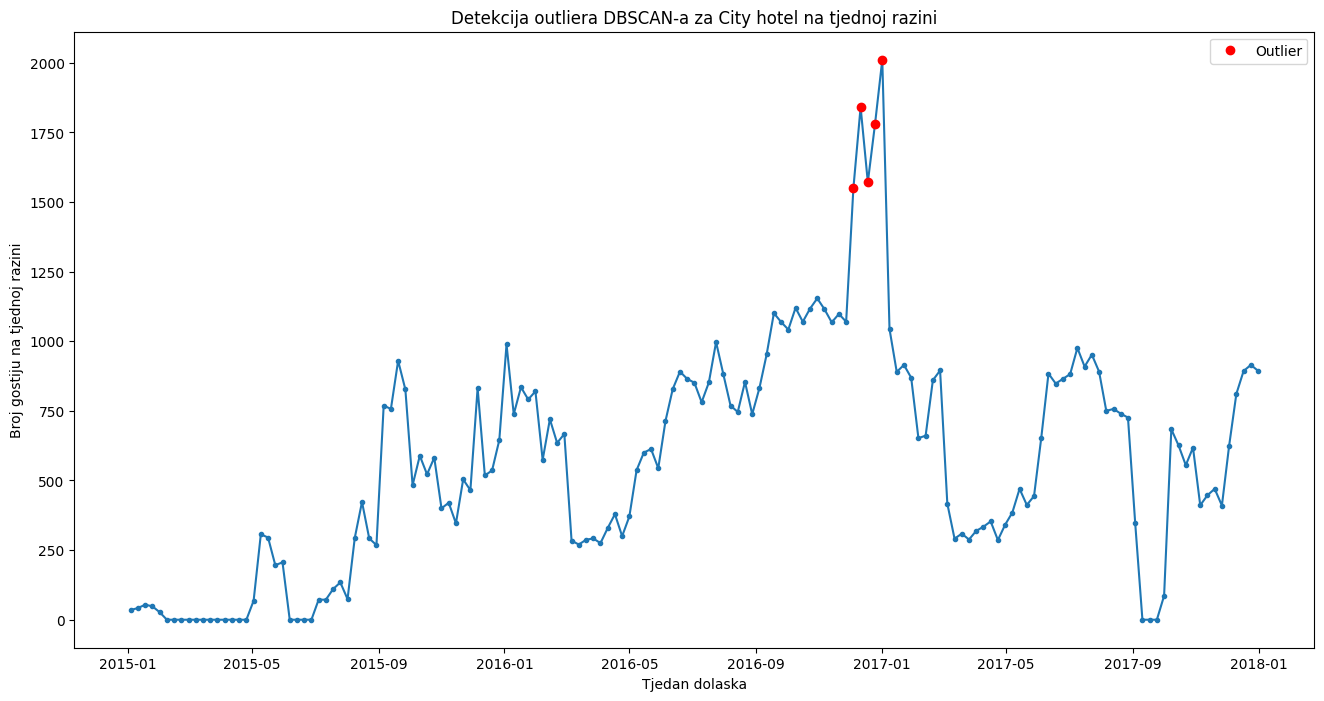

In [101]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


## Mjesečna razina (promatramo mjesečnu fluktuaciju broja gostiju) za oba hotela

In [38]:
NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity .resample('ME').sum().to_frame()
NumberOfGuestsMonthlyCity .head(5)

ukupno_gostiju
datum_dolaska                
2015-01-31              206.0
2015-02-28                0.0
2015-03-31                0.0
2015-04-30                0.0
2015-05-31             1072.0

In [39]:
NumberOfGuestsMonthlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort  = NumberOfGuestsMonthlyResort.resample('ME').sum().to_frame()
NumberOfGuestsMonthlyResort.head(5)

ukupno_gostiju
datum_dolaska                
2015-07-31             2300.0
2015-08-31             2318.0
2015-09-30             2013.0
2015-10-31             2108.0
2015-11-30             1534.0

##### Priprema podataka za mjesečnu univarijatnu analizu


In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [41]:
monthly_city_data = NumberOfGuestsMonthlyCity['ukupno_gostiju'].values.reshape(-1,1)
monthly_city_data_stand = scaler.fit_transform(monthly_city_data)

In [42]:
monthly_resort_data = NumberOfGuestsMonthlyResort['ukupno_gostiju'].values.reshape(-1,1)
monthly_resort_data_stand = scaler.fit_transform(monthly_resort_data)

In [43]:
pd_resort_monthly_data = NumberOfGuestsMonthlyResort[['ukupno_gostiju']].copy()
pd_resort_monthly_data['ukupno_gostiju'] = scaler.fit_transform(pd_resort_monthly_data['ukupno_gostiju'].values.reshape(-1,1))


In [44]:
pd_city_monthly_data = NumberOfGuestsMonthlyCity[['ukupno_gostiju']].copy()
pd_city_monthly_data['ukupno_gostiju'] = scaler.fit_transform(pd_city_monthly_data['ukupno_gostiju'].values.reshape(-1,1))


### Naivan pristup : interkvartalni rang

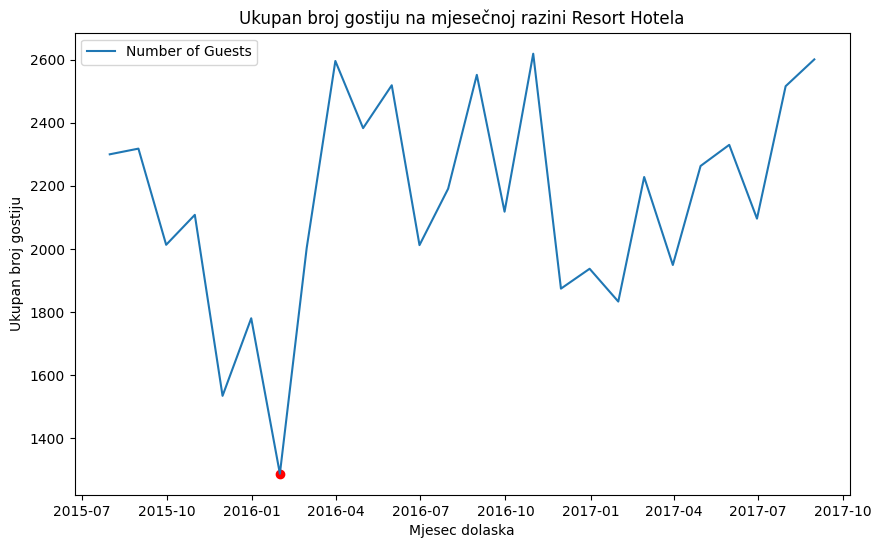

In [23]:
q11 = np.percentile(NumberOfGuestsMonthlyResort['ukupno_gostiju'], 25)
q31 = np.percentile(NumberOfGuestsMonthlyResort['ukupno_gostiju'],75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((NumberOfGuestsMonthlyResort['ukupno_gostiju'] < q11 - threshold1) | (NumberOfGuestsMonthlyResort['ukupno_gostiju'] > q31 + threshold1))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsMonthlyResort.index, NumberOfGuestsMonthlyResort['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers1[0]:
    plt.scatter(NumberOfGuestsMonthlyResort.index[outlier], NumberOfGuestsMonthlyResort['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Mjesec dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na mjesečnoj razini Resort Hotela')
plt.legend()
plt.show()


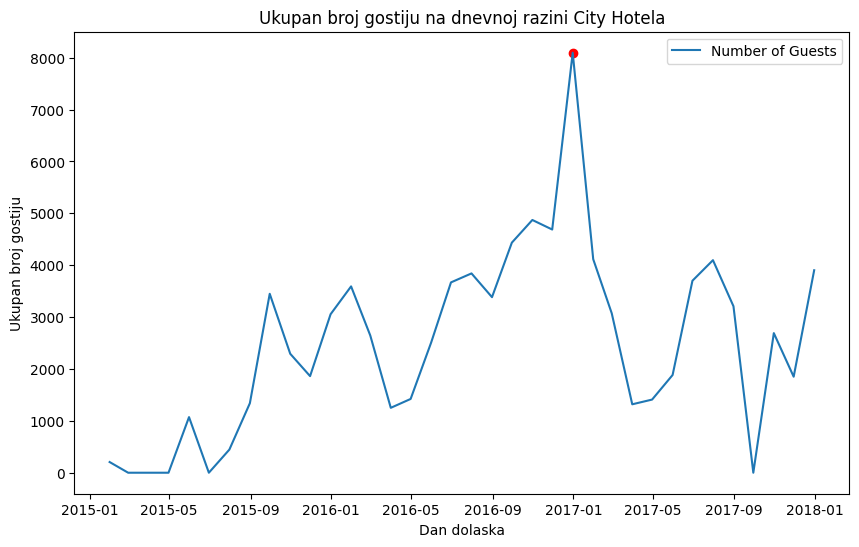

In [24]:
q12 = np.percentile(NumberOfGuestsMonthlyCity ['ukupno_gostiju'], 25)
q32 = np.percentile(NumberOfGuestsMonthlyCity['ukupno_gostiju'],75)
iqr2 = q32 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((NumberOfGuestsMonthlyCity['ukupno_gostiju'] < q12 - threshold2) | (NumberOfGuestsMonthlyCity['ukupno_gostiju'] > q32 + threshold2))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsMonthlyCity.index, NumberOfGuestsMonthlyCity['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers2[0]:
    plt.scatter(NumberOfGuestsMonthlyCity.index[outlier], NumberOfGuestsMonthlyCity['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini City Hotela')
plt.legend()
plt.show()

### ADTK OutlierDetector

" performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API."

In [25]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor


In [26]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_resort = outlier_detector.fit_detect(NumberOfGuestsMonthlyResort)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False  True False  True False False False False False
 False False False False False False False False False False False False
 False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  is_outliers.loc[df.dropna().index] = (


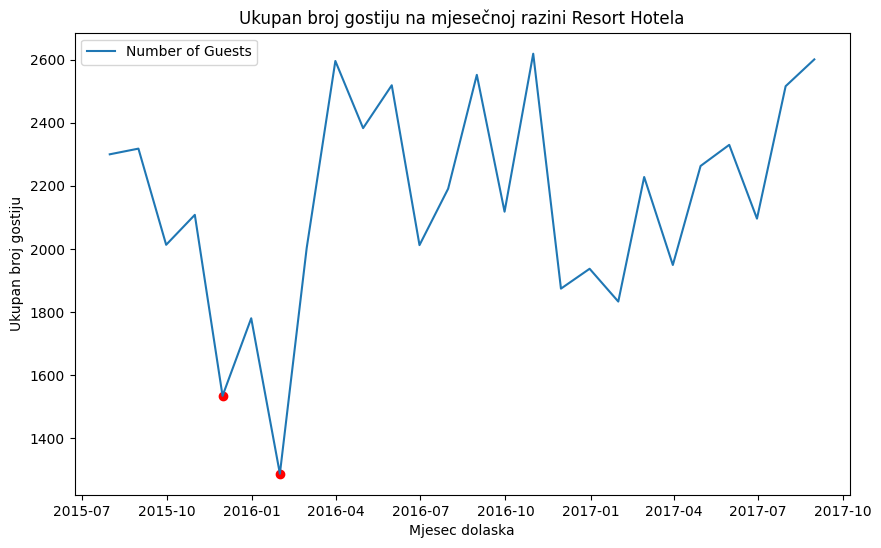

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsMonthlyResort.index, NumberOfGuestsMonthlyResort['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_resort[anomalies_resort].index:
    if anomaly_date in NumberOfGuestsMonthlyResort.index:
        plt.scatter(anomaly_date, NumberOfGuestsMonthlyResort.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Mjesec dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na mjesečnoj razini Resort Hotela')
plt.legend()
plt.show()


In [28]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_city = outlier_detector.fit_detect(NumberOfGuestsMonthlyCity)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  is_outliers.loc[df.dropna().index] = (


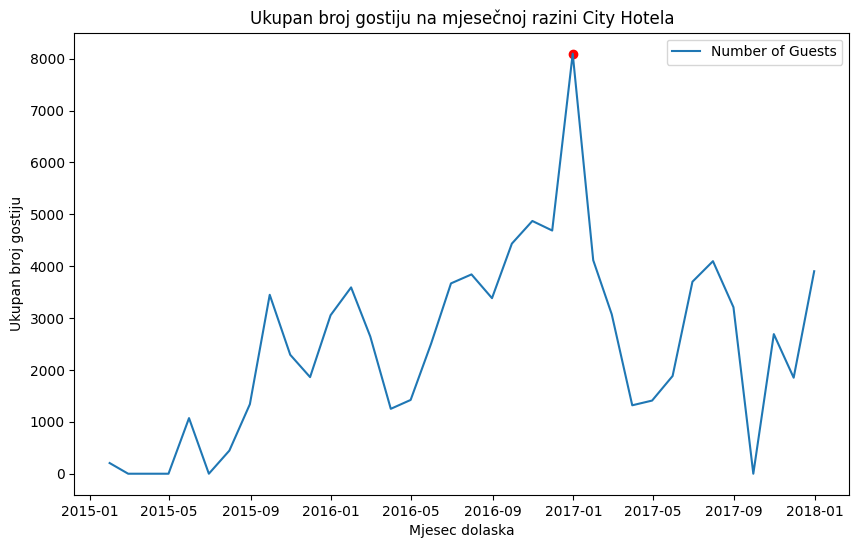

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsMonthlyCity.index, NumberOfGuestsMonthlyCity['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_city[anomalies_city].index:
    if anomaly_date in NumberOfGuestsMonthlyCity.index:
        plt.scatter(anomaly_date, NumberOfGuestsMonthlyCity.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Mjesec dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na mjesečnoj razini City Hotela')
plt.legend()
plt.show()


### (Unsupervised) Isolation Forests na univarijatnim podacima 

In [30]:
from sklearn.ensemble import IsolationForest 

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

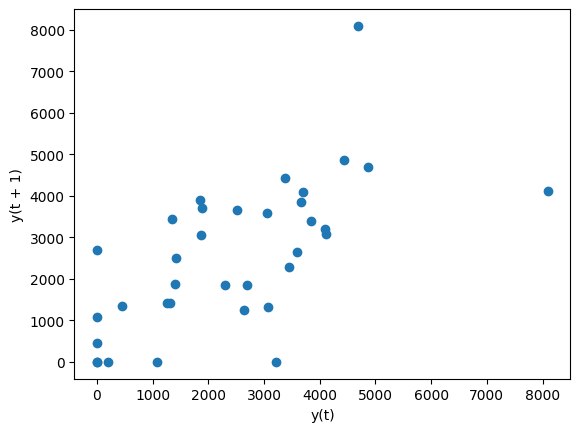

In [31]:
pd.plotting.lag_plot(NumberOfGuestsMonthlyCity, lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

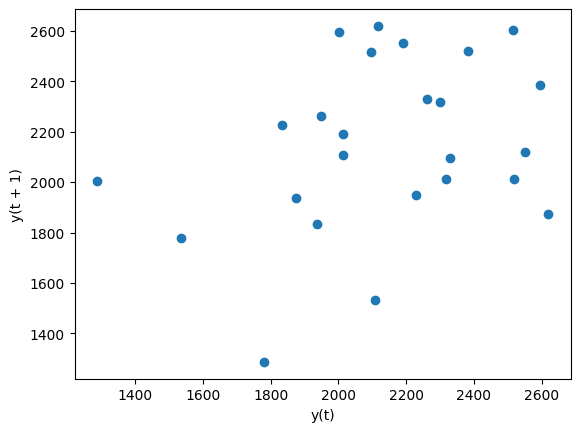

In [32]:
pd.plotting.lag_plot(NumberOfGuestsMonthlyResort, lag=1)

In [33]:
outliers_fraction = float(0.01)

In [34]:
if_model_city = IsolationForest(random_state = 0, 
                                contamination = outliers_fraction,
                                bootstrap=False,
                                verbose=True
                                )

In [35]:
if_model_city.fit(monthly_city_data_stand)

IsolationForest(contamination=0.01, random_state=0, verbose=True)

In [36]:
NumberOfGuestsMonthlyCity['score'] = if_model_city.decision_function(monthly_city_data_stand )
NumberOfGuestsMonthlyCity['anomaly_value'] = if_model_city.predict(monthly_city_data_stand )
NumberOfGuestsMonthlyCity.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-01-31              206.0  0.140378              1
2015-02-28                0.0  0.233510              1
2015-03-31                0.0  0.233510              1
2015-04-30                0.0  0.233510              1
2015-05-31             1072.0  0.226120              1

anomaly_value
 1    35
-1     1
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

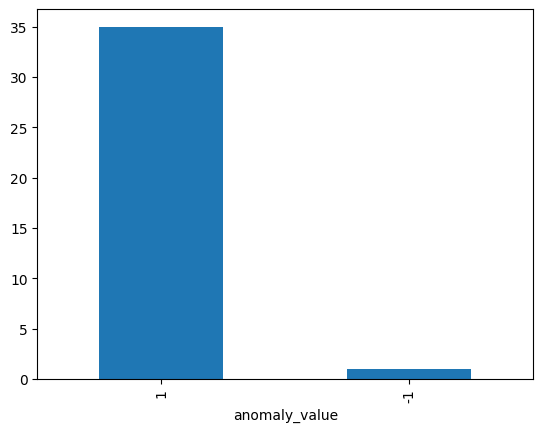

In [37]:
outliers_city = NumberOfGuestsMonthlyCity[NumberOfGuestsMonthlyCity['anomaly_value'] == -1]
outlier_index = list(outliers_city.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsMonthlyCity['anomaly_value'].value_counts())
NumberOfGuestsMonthlyCity['anomaly_value'].value_counts().plot(kind = 'bar')

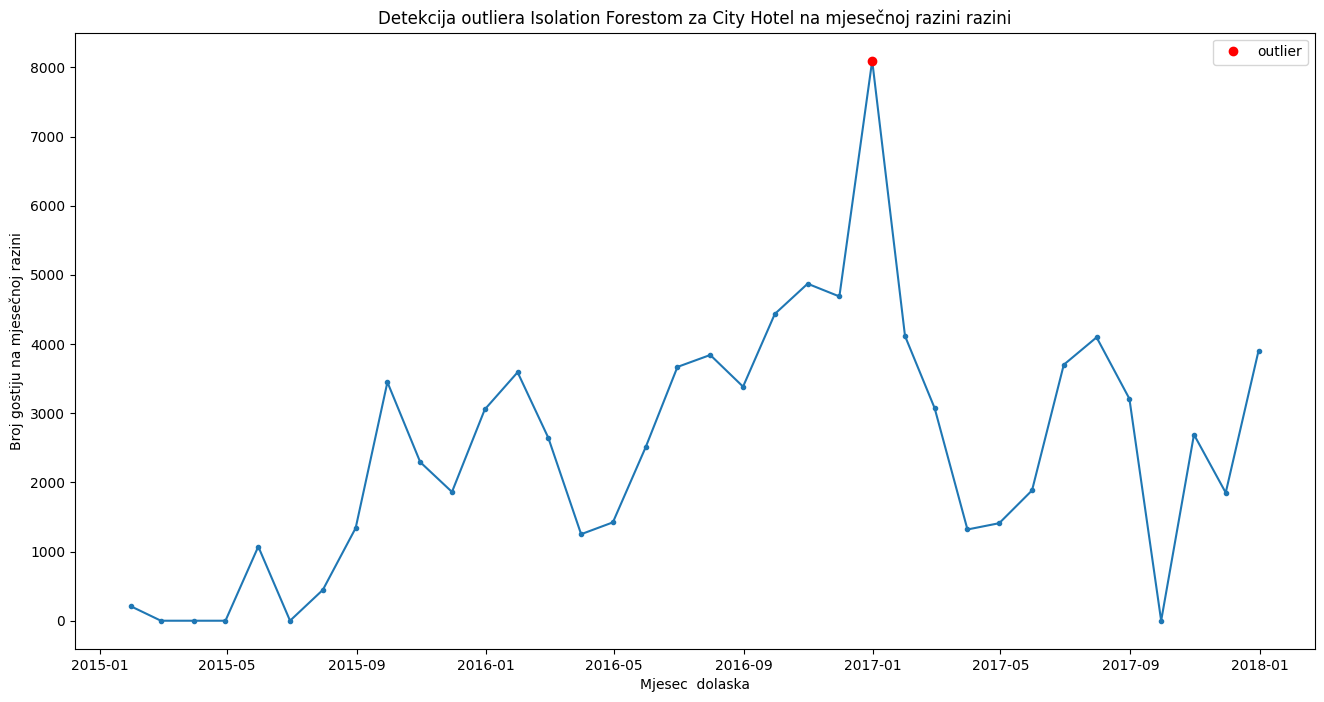

In [38]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsMonthlyCity['ukupno_gostiju'], marker = '.')
plt.plot(outliers_city['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za City Hotel na mjesečnoj razini razini')

plt.xlabel('Mjesec  dolaska')
plt.ylabel('Broj gostiju na mjesečnoj razini')
plt.legend()

In [39]:
outliers_fraction = float(0.01)

In [40]:
if_model_resort = IsolationForest(random_state = 0, 
                                  contamination = outliers_fraction ,
                                  bootstrap=False,
                                  verbose=True
                                 )

In [41]:
if_model_resort.fit(monthly_resort_data_stand) 

IsolationForest(contamination=0.01, random_state=0, verbose=True)

In [42]:
NumberOfGuestsMonthlyResort['score'] = if_model_resort.decision_function(monthly_resort_data_stand) 
NumberOfGuestsMonthlyResort['anomaly_value'] = if_model_resort.predict(monthly_resort_data_stand) 
NumberOfGuestsMonthlyResort.head()

ukupno_gostiju     score  anomaly_value
datum_dolaska                                         
2015-07-31             2300.0  0.265462              1
2015-08-31             2318.0  0.271153              1
2015-09-30             2013.0  0.282636              1
2015-10-31             2108.0  0.273018              1
2015-11-30             1534.0  0.066591              1

anomaly_value
 1    25
-1     1
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

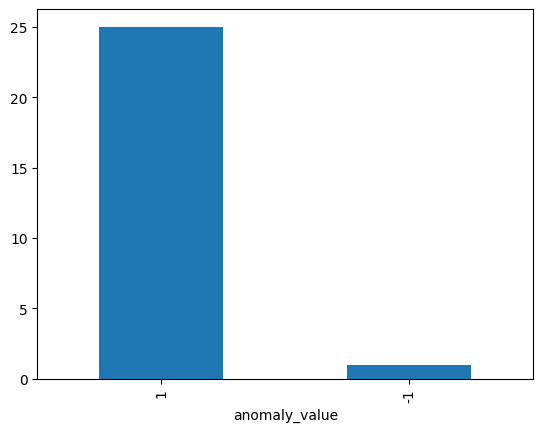

In [43]:
outliers_resort = NumberOfGuestsMonthlyResort[NumberOfGuestsMonthlyResort['anomaly_value'] == -1]
outlier_index_resort = list(outliers_resort.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsMonthlyResort['anomaly_value'].value_counts())
NumberOfGuestsMonthlyResort['anomaly_value'].value_counts().plot(kind = 'bar')

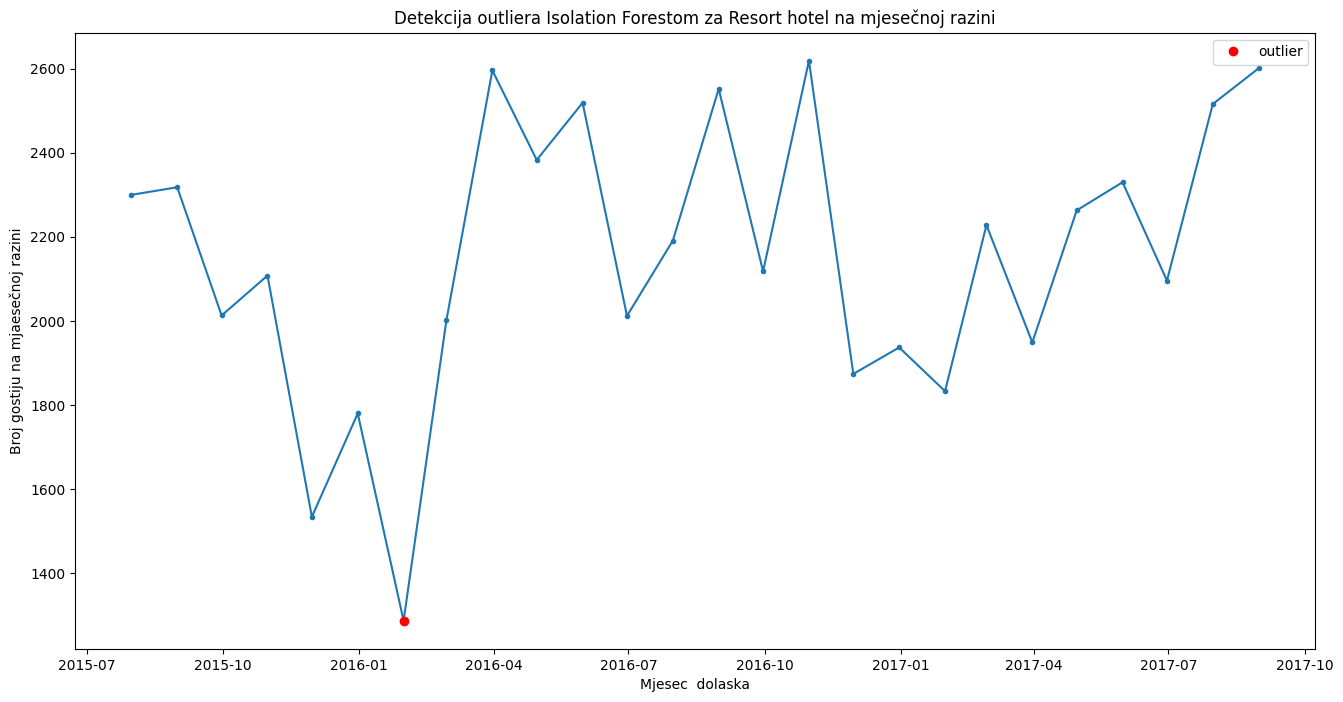

In [44]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsMonthlyResort['ukupno_gostiju'], marker = '.')
plt.plot(outliers_resort['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za Resort hotel na mjesečnoj razini')

plt.xlabel('Mjesec  dolaska')
plt.ylabel('Broj gostiju na mjaesečnoj razini')
plt.legend()

### One class SVM

In [45]:
from sklearn.svm import OneClassSVM

In [46]:
outliers_fraction = float(0.05)

In [51]:
osvm_city = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_city.fit(monthly_city_data_stand)



OneClassSVM(gamma=0.01, nu=0.01)

In [52]:
NumberOfGuestsMonthlyCity['anomaly_value_osvm'] = osvm_city.predict(monthly_city_data_stand)

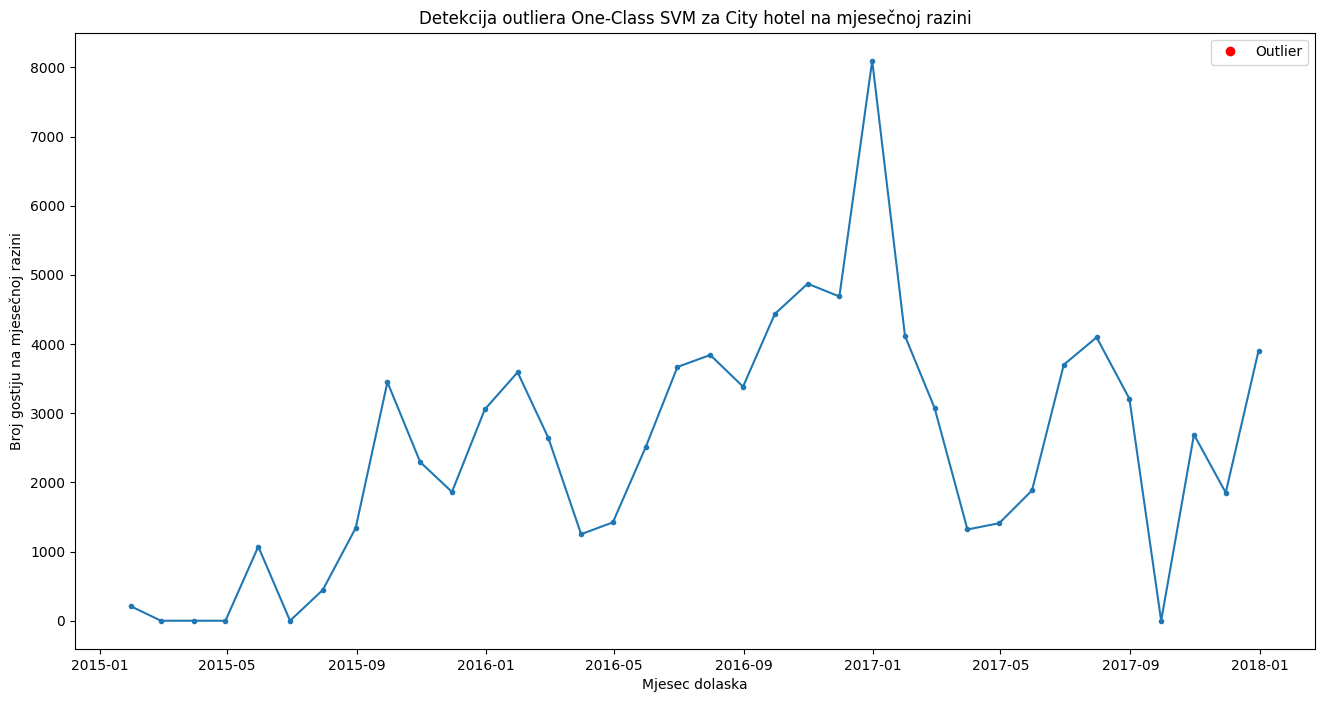

In [53]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsMonthlyCity['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsMonthlyCity[NumberOfGuestsMonthlyCity['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za City hotel na mjesečnoj razini')
plt.xlabel('Mjesec dolaska')
plt.ylabel('Broj gostiju na mjesečnoj razini')
plt.legend()
plt.show()


In [54]:
osvm_resort = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_resort.fit(monthly_resort_data_stand)



OneClassSVM(gamma=0.01, nu=0.01)

In [55]:
NumberOfGuestsMonthlyResort['anomaly_value_osvm'] = osvm_resort.predict(monthly_resort_data_stand)

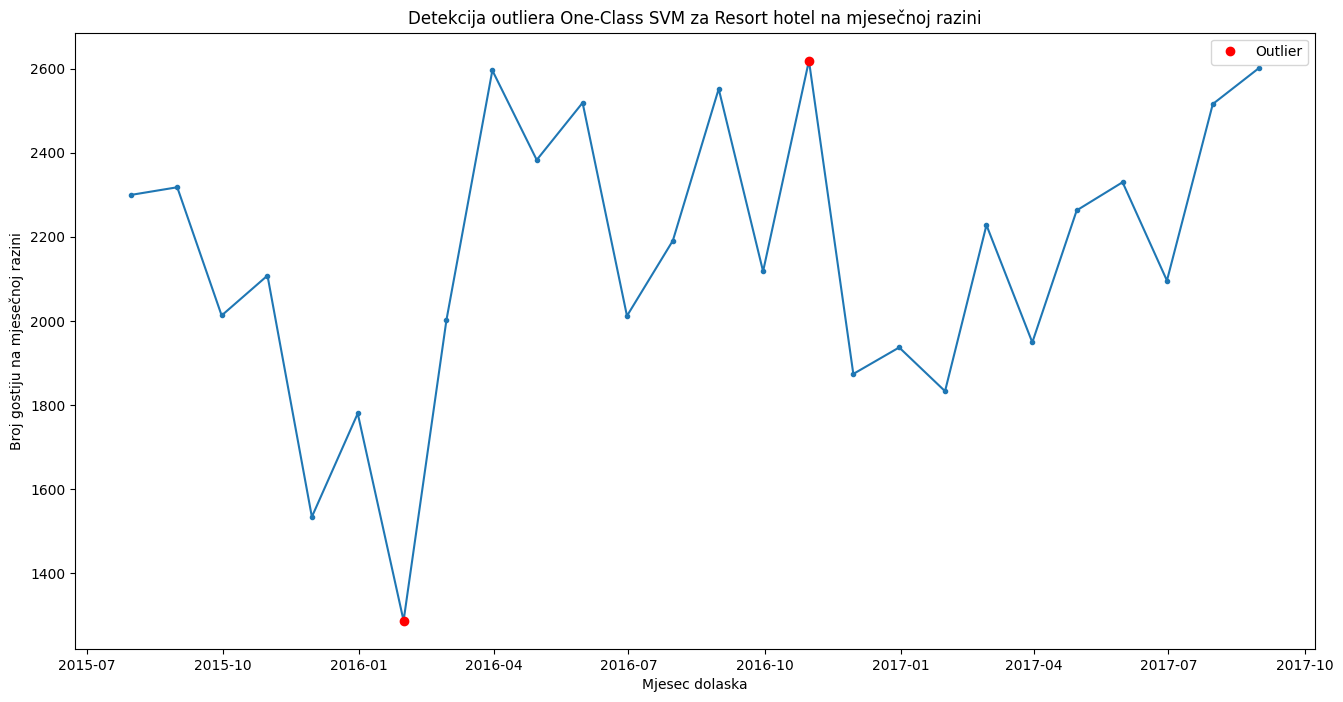

In [56]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsMonthlyResort['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsMonthlyResort[NumberOfGuestsMonthlyResort['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za Resort hotel na mjesečnoj razini')
plt.xlabel('Mjesec dolaska')
plt.ylabel('Broj gostiju na mjesečnoj razini')
plt.legend()
plt.show()


### DBSCAN

In [58]:
from sklearn.cluster import DBSCAN

In [68]:
outlier_detection = DBSCAN(
 eps = .8, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_resort = outlier_detection.fit_predict(pd_resort_monthly_data)

In [69]:
NumberOfGuestsMonthlyResort['anomaly_value_dbscan'] = clusters_resort

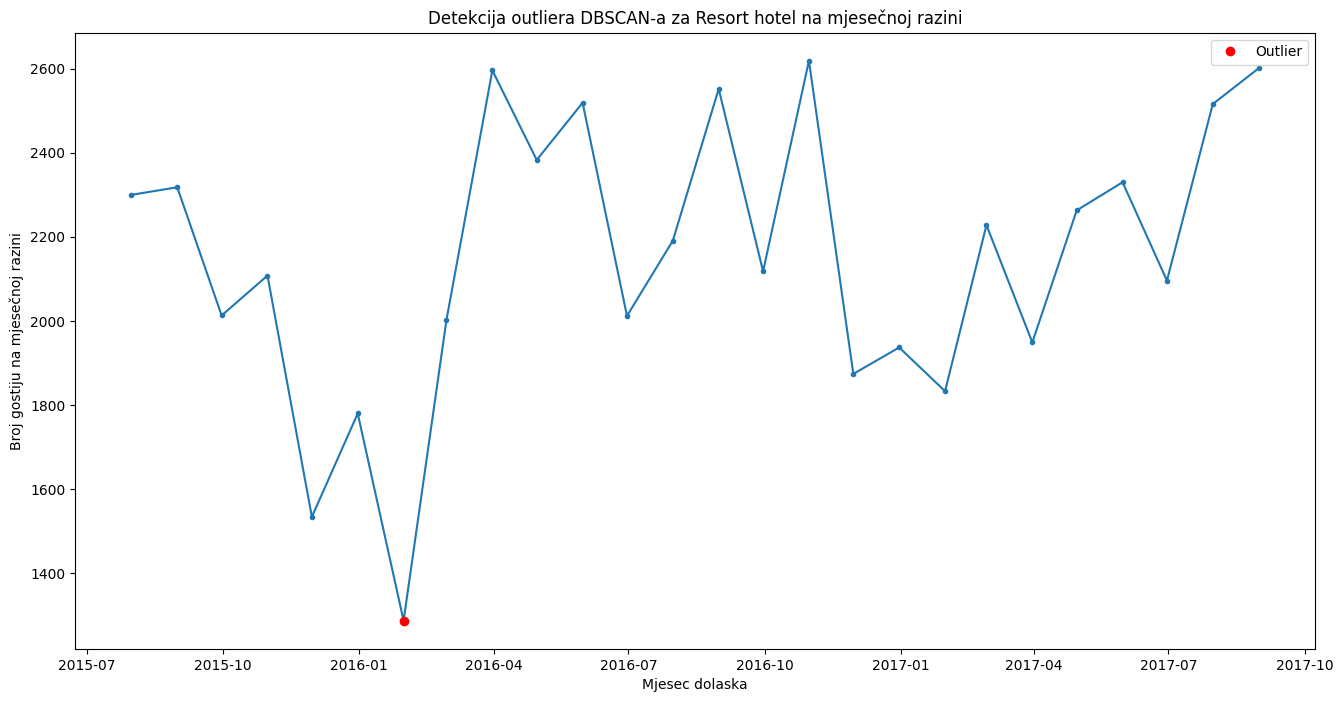

In [70]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsMonthlyResort['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsMonthlyResort[NumberOfGuestsMonthlyResort['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za Resort hotel na mjesečnoj razini')
plt.xlabel('Mjesec dolaska')
plt.ylabel('Broj gostiju na mjesečnoj razini')
plt.legend()
plt.show()


In [71]:
outlier_detection = DBSCAN(
 eps = .8, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_city = outlier_detection.fit_predict(pd_city_monthly_data)

In [73]:
NumberOfGuestsMonthlyCity['anomaly_value_dbscan'] = clusters_city


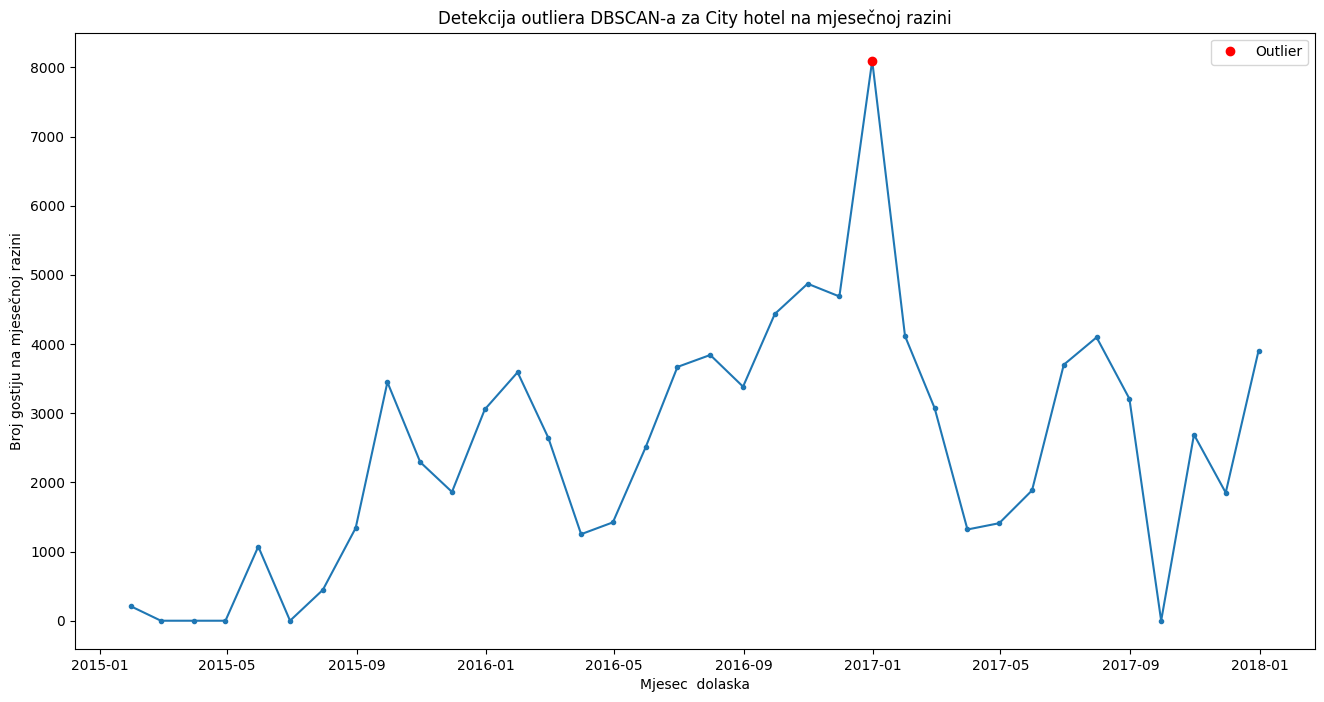

In [74]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsMonthlyCity['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsMonthlyCity[NumberOfGuestsMonthlyCity['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za City hotel na mjesečnoj razini')
plt.xlabel('Mjesec  dolaska')
plt.ylabel('Broj gostiju na mjesečnoj razini')
plt.legend()
plt.show()


## Sliding window approach

In [104]:
window_size = int(1.0 * len(NumberOfGuestsDailyCity))

In [105]:
from numpy.typing import NDArray
from scipy import stats

def find_outlier_in_window(window: NDArray[float], method: str = 'iqr'):
    if method == 'iqr':
        q1 = np.percentile(window, 25)
        q3 = np.percentile(window, 75)
        iqr = q3 - q1
        threshold = 1.5 * iqr
        outlier_indexes = np.where((window < q1 - threshold) | (window > q3 + threshold))[0]
    
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(window))
        outlier_indexes = np.where(z_scores > 2)[0]  

    elif method == 'percentile':
        lower_bound = np.percentile(window, 1)  
        upper_bound = np.percentile(window, 99)  
        outlier_indexes = np.where((window < lower_bound) | (window > upper_bound))[0]
    
    else:
        raise ValueError("Invalid method. Choose 'iqr', 'zscore', or 'percentile'.")

    return outlier_indexes

In [106]:
def find_outliers(data: NDArray[float], window_size: int,method: str = 'iqr'):
    outlier_list = []
    for i in range(0, len(data), window_size):
        window = data[i:i + window_size]
        window_outliers = find_outlier_in_window(window,method=method)
        adjusted_indices = [i + outlier for outlier in window_outliers]
        outlier_list.extend(adjusted_indices)
    return outlier_list

In [107]:
outlier_indexes = find_outliers(NumberOfGuestsDailyCity,window_size,'zscore')#'percentile')

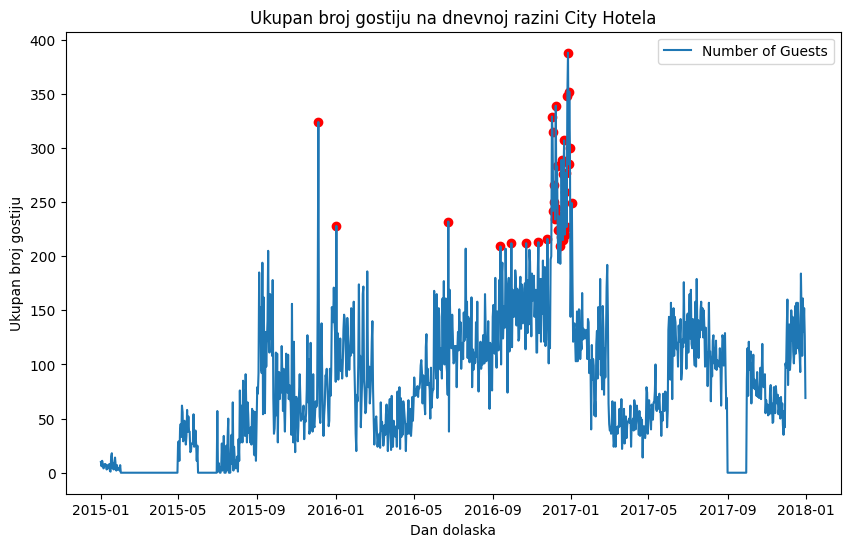

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyCity.index, NumberOfGuestsDailyCity['ukupno_gostiju'], label='Number of Guests')


for outlier_index in outlier_indexes:
    plt.scatter(NumberOfGuestsDailyCity.index[outlier_index], NumberOfGuestsDailyCity['ukupno_gostiju'].iloc[outlier_index], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini City Hotela')
plt.legend()
plt.show()

In [108]:
window_size = int(1.0 * len(NumberOfGuestsDailyResort))

In [111]:
outlier_indexes = find_outliers(NumberOfGuestsDailyResort,window_size,'iqr')#'percentile')

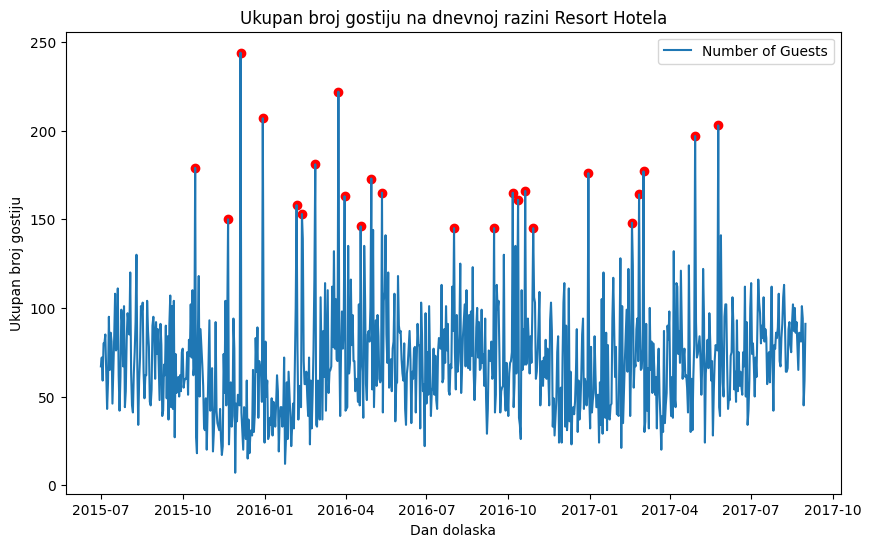

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsDailyResort.index, NumberOfGuestsDailyResort['ukupno_gostiju'], label='Number of Guests')


for outlier_index in outlier_indexes:
    plt.scatter(NumberOfGuestsDailyResort.index[outlier_index],NumberOfGuestsDailyResort['ukupno_gostiju'].iloc[outlier_index], color='red')

plt.xlabel('Dan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na dnevnoj razini Resort Hotela')
plt.legend()
plt.show()